# Baltimore watershed

In [1]:
watershed = 'Baltimore'

%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/5-Baltimore/DailyData'

In [2]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

In [3]:
# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

In [4]:
# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed
                'Precipitation':(0,400), 
                'AirTemperature':(-20,50), 
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (5,100),  ### avoid erroneous values
                'SoilTemperature': (-20,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]
    
    for i in range(len(prep.columns)):
        col = prep.columns[i]
      
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))
        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        

        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])        

        # plt.figure(i)
        # prep_new[prep_new.columns[i]].plot()
    
    return prep

In [5]:
# Data were accessed on 5/26/2020

### Discharge

In [6]:
# Streamflow data from USGS
# USGS 01589352 GWYNNS FALLS AT WASHINGTON BLVD AT BALTIMORE, MD
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=01589352&referred_module=sw&period=&begin_date=2005-01-01&end_date=2019-07-20',
                    header = 0,skiprows = 27 ,parse_dates = True,sep = '\t' ,infer_datetime_format = True)
data.head(3)


agency_cd   site_no    datetime 68298_00060_00003 68298_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  01589352  2005-01-01              42.0                  A:e
2      USGS  01589352  2005-01-02              42.0                  A:e

In [7]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['68298_00060_00003']))
prep.columns = ['GWYNNS_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)

GWYNNS_Discharge
datetime                    
2005-01-01              42.0
2005-01-02              42.0
2005-01-03              42.0

GWYNNS_Discharge
datetime                    
2019-07-18             151.0
2019-07-19              59.2
2019-07-20              48.3

GWYNNS_Discharge


GWYNNS_Discharge
2005-01-01           1188.60
2005-01-02           1188.60
2005-01-03           1188.60
2005-01-04           1202.75
2005-01-05           2999.80

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

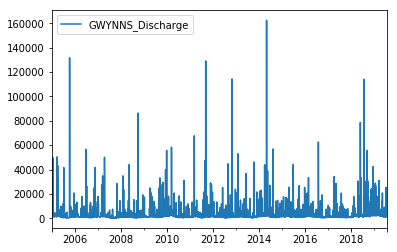

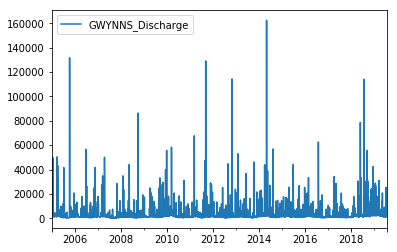

In [8]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]* 28.3 #(ft3/s to to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge')            
Discharge = copy.deepcopy(df)
Discharge.plot()
Discharge.head() 

In [9]:
# streamflow data 2
# The data is not included in the final table because of the poor quality
#data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-bes.2070.180&entityid=eb1483e693ab6b804cb76219a3c9baf3',
 #                   header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
#data.head()

In [10]:
#prep = copy.deepcopy(data[['Q']])
#prep.rename(columns={'Q':'GF_Discharge'},inplace = True)
#prep = threC(prep,'Discharge')
#prep = prep.groupby(prep.index.date).mean()

In [11]:
#indexUnique = pd.date_range(start='2012-10-24', end='2016-11-19')

#ready_columns = pd.unique(prep.columns)
#NAN = np.nan*np.ones([len(indexUnique),len(ready_columns)])
#df = pd.DataFrame(NAN, index=indexUnique, columns=ready_columns) # create an empty data frame

#for i in np.arange(len(ready_columns)):
#    tab = prep[ready_columns[i]]
#    for j in np.arange(len(tab)):
#        df.loc[tab.index[j]][ready_columns[i]] = tab.iloc[j]
            
#Discharge2 = copy.deepcopy(df)
#Discharge2.plot()
#Discharge2.head()

### Hydrometeorology

### Precipitation

In [57]:
path = os.getcwd().rsplit('/',1)[0] +'/RawData/'

In [58]:
data = pd.read_excel(path +'raw_baltimore_precipitation.xlsx',header = 0,index_col = 'Date_Time_(EST)')
data.head(2)

Site Rain_Gauge_ID  \
Date_Time_(EST)                                                  
2009-04-11 03:49:00  Carrie Murray Nature Center    WXCMNC_RG1   
2009-04-11 04:10:00  Carrie Murray Nature Center    WXCMNC_RG1   

                     Precipitation_(mm)  
Date_Time_(EST)                          
2009-04-11 03:49:00               0.254  
2009-04-11 04:10:00               0.254

In [59]:
data['Site'].unique()

array(['Carrie Murray Nature Center', 'Carroll Park Golf Course\xa0',
       'Dead Run near Catonsville', 'Glyndon Elementary School',
       'Gwynns Falls Near Delight', 'McDonogh School',
       'Oregon Ridge Park', 'UMBC Campus'], dtype=object)

In [60]:
df_lst = []
for site in data['Site'].unique():
    print(site)
    df = data[data['Site']==site]
    df = df[['Precipitation_(mm)']]
    df.columns = [site.split(' ')[0] +'_Precipitation']
    df = threC(df,'Precipitation')
    display(df.head())
    df_lst.append(df)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum")

Carrie Murray Nature Center


Carrie_Precipitation
Date_Time_(EST)                          
2009-04-11 03:49:00                 0.254
2009-04-11 04:10:00                 0.254
2009-04-11 04:22:00                 0.254
2009-04-11 04:25:00                 0.254
2009-04-11 04:27:00                 0.254

Carroll Park Golf Course 


Carroll_Precipitation
Date_Time_(EST)                           
2009-04-11 03:55:00                  0.254
2009-04-11 03:59:00                  0.254
2009-04-11 04:00:00                  0.254
2009-04-11 04:02:00                  0.254
2009-04-11 04:04:00                  0.254

Dead Run near Catonsville


Dead_Precipitation
Date_Time_(EST)                        
2009-05-11 15:59:00               0.254
2009-05-11 16:01:00               0.254
2009-05-11 16:03:00               0.254
2009-05-11 16:05:00               0.254
2009-05-11 16:06:00               0.254

Glyndon Elementary School


Glyndon_Precipitation
Date_Time_(EST)                           
2009-06-30 12:16:00                  0.254
2009-06-30 12:17:00                  0.254
2009-06-30 12:19:00                  0.254
2009-06-30 12:20:00                  0.254
2009-06-30 12:21:00                  0.762

Gwynns Falls Near Delight


Gwynns_Precipitation
Date_Time_(EST)                          
2009-06-09 15:49:00                 0.254
2009-06-09 15:50:00                 0.762
2009-06-09 15:51:00                 0.762
2009-06-09 15:52:00                 0.762
2009-06-09 15:53:00                 0.254

McDonogh School


McDonogh_Precipitation
Date_Time_(EST)                            
2009-04-11 03:57:00                   0.254
2009-04-11 04:14:00                   0.254
2009-04-11 04:23:00                   0.254
2009-04-11 04:49:00                   0.254
2009-04-11 04:59:00                   0.254

Oregon Ridge Park


Oregon_Precipitation
Date_Time_(EST)                          
2009-04-11 03:58:00                 0.254
2009-04-11 04:10:00                 0.254
2009-04-11 04:20:00                 0.254
2009-04-11 04:31:00                 0.254
2009-04-11 04:41:00                 0.254

UMBC Campus


UMBC_Precipitation
Date_Time_(EST)                        
2009-04-11 03:57:00               0.254
2009-04-11 04:04:00               0.254
2009-04-11 04:10:00               0.254
2009-04-11 04:13:00               0.254
2009-04-11 04:18:00               0.254

The final table is:


Carrie_Precipitation Carroll_Precipitation Dead_Precipitation  \
2009-04-11               33.528                 53.34                NaN   
2009-04-12                  NaN                   NaN                NaN   

           Glyndon_Precipitation Gwynns_Precipitation McDonogh_Precipitation  \
2009-04-11                   NaN                  NaN                 35.306   
2009-04-12                   NaN                  NaN                    NaN   

           Oregon_Precipitation UMBC_Precipitation  
2009-04-11               46.482             37.084  
2009-04-12                0.254                NaN

Carrie_Precipitation Carroll_Precipitation Dead_Precipitation  \
2017-12-25                 0.59                   NaN                NaN   
2017-12-30                  NaN                  1.56                NaN   

           Glyndon_Precipitation Gwynns_Precipitation McDonogh_Precipitation  \
2017-12-25                  0.49                0.494                  0.254   
2017-12-30                   NaN                  NaN                    NaN   

           Oregon_Precipitation UMBC_Precipitation  
2017-12-25                0.764                NaN  
2017-12-30                  NaN                NaN

In [61]:
prep.columns = ['Carrie_Precipitation', 'Carroll_Precipitation', 'DeadRun_Precipitation',
       'Glyndon_Precipitation', 'Gwynns_Precipitation',
       'McDonogh_Precipitation', 'Oregon_Precipitation', 'UMBC_Precipitation']

In [62]:
prep.head(3)

Carrie_Precipitation Carroll_Precipitation DeadRun_Precipitation  \
2009-04-11               33.528                 53.34                   NaN   
2009-04-12                  NaN                   NaN                   NaN   
2009-04-13                1.778                 4.826                   NaN   

           Glyndon_Precipitation Gwynns_Precipitation McDonogh_Precipitation  \
2009-04-11                   NaN                  NaN                 35.306   
2009-04-12                   NaN                  NaN                    NaN   
2009-04-13                   NaN                  NaN                  3.048   

           Oregon_Precipitation UMBC_Precipitation  
2009-04-11               46.482             37.084  
2009-04-12                0.254                NaN  
2009-04-13                5.334              4.572

Carrie_Precipitation
Carroll_Precipitation
DeadRun_Precipitation
Glyndon_Precipitation
Gwynns_Precipitation
McDonogh_Precipitation
Oregon_Precipitation
UMBC_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

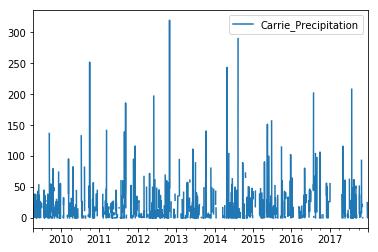

<Figure size 432x288 with 0 Axes>

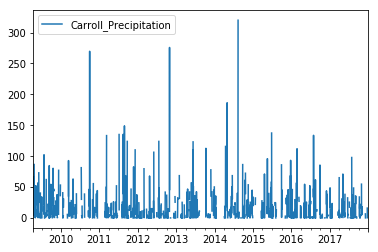

<Figure size 432x288 with 0 Axes>

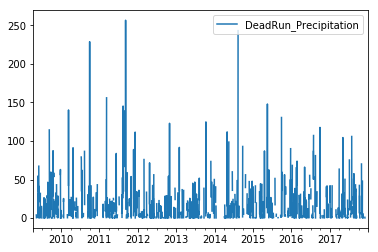

<Figure size 432x288 with 0 Axes>

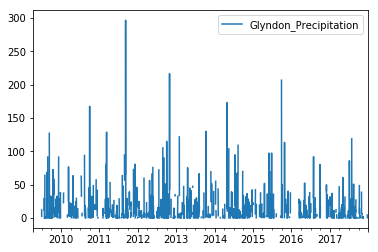

<Figure size 432x288 with 0 Axes>

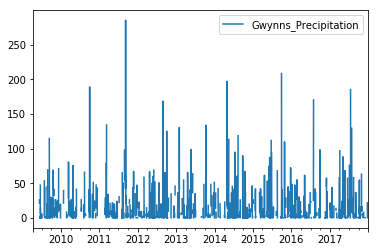

<Figure size 432x288 with 0 Axes>

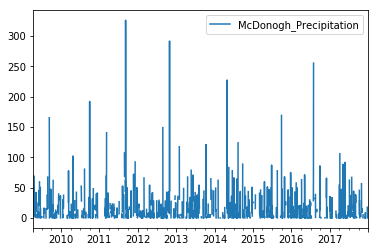

<Figure size 432x288 with 0 Axes>

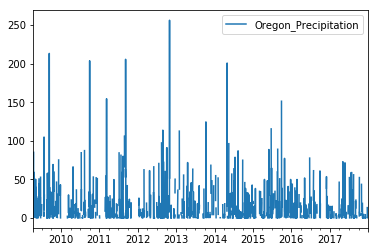

<Figure size 432x288 with 0 Axes>

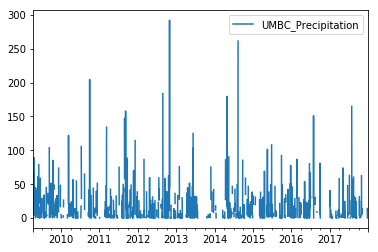

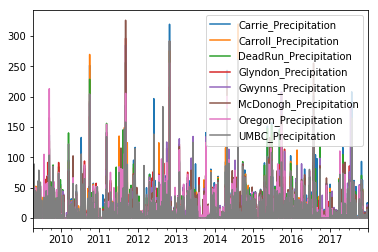

In [63]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)]) ####
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
df = threC(df,'Precipitation')
Precipitation = copy.deepcopy(df)
Precipitation.fillna(0, inplace=True) # tipping bucket measurement
Precipitation.plot()

In [18]:
# 2. AirTemperature 


In [19]:
# 3. SolarRadiation


In [20]:
# 4. Humidity

In [21]:
# 5. WindDirection


In [22]:
# 6. WindSpeed


In [23]:
# 7. SWE


In [24]:
# 8. SnowDepth


In [25]:
# 9. Snowmelt


In [26]:
# 10. Vapor Pressure 


### 11. Soil Moisture

In [1]:
#https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-bes.3400.160&entityid=bb3c8236790cb1e209c33f2d5d327dd7

In [21]:
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-bes.3400.140&entityid=ec4bca16cb78dae6a9dcf1a30668b3e6',
                  header = 0)
data.head()

Site 10cm_depth_reading_ID  Port 1 VWC  Port 1 VWC Flag  \
0  LEA1       9/15/2011 14:00       0.250              NaN   
1  LEA1       9/15/2011 15:00       0.249              NaN   
2  LEA1       9/15/2011 16:00       0.249              NaN   
3  LEA1       9/15/2011 17:00       0.249              NaN   
4  LEA1       9/15/2011 18:00       0.248              NaN   

   Port 1 Temperature  Port 1 Temperature Flag  Port 2 VWC Port 2 VWC Flag  \
0                20.2                      NaN       0.252             NaN   
1                20.1                      NaN       0.255             NaN   
2                20.1                      NaN       0.256             NaN   
3                20.0                      NaN       0.260             NaN   
4                19.8                      NaN       0.259             NaN   

   Port 2 Temperature  Port 2 Temperature Flag  ...  Port 3 Temperature  \
0                20.5                      NaN  ...                20.7   
1                20.5                      NaN  ...                20.7   
2                20.5                      NaN  ...                20.7   
3                20.4                      NaN  ...                20.6   
4                20.3                      NaN  ...                20.4   

   Port 3 Temperature Flag  Port 4 VWC  Port 4 VWC Flag  Port 4 Temperature  \
0                      NaN       0.234              NaN                20.4   
1                      NaN       0.234              NaN                20.4   
2                      NaN       0.233              NaN                20.3   
3                      NaN       0.233              NaN                20.1   
4                      NaN       0.231              NaN                19.8   

   Port 4 Temperature Flag  Port 5 VWC  Port 5 VWC Flag  Port 5 Temperature  \
0                      NaN       0.275              NaN                20.6   
1                      NaN       0.275              NaN                20.6   
2                      NaN       0.275              NaN                20.5   
3                      NaN       0.275              NaN                20.5   
4                      NaN       0.275              NaN                20.3   

   Port 5 Temperature Flag  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  

[5 rows x 22 columns]

In [22]:
data.set_index(data.columns[1],inplace = True)
data.index.rename('DateTime', inplace = True)
data.index = pd.to_datetime(data.index)
data.head(3)

Site  Port 1 VWC  Port 1 VWC Flag  Port 1 Temperature  \
DateTime                                                                     
2011-09-15 14:00:00  LEA1       0.250              NaN                20.2   
2011-09-15 15:00:00  LEA1       0.249              NaN                20.1   
2011-09-15 16:00:00  LEA1       0.249              NaN                20.1   

                     Port 1 Temperature Flag  Port 2 VWC Port 2 VWC Flag  \
DateTime                                                                   
2011-09-15 14:00:00                      NaN       0.252             NaN   
2011-09-15 15:00:00                      NaN       0.255             NaN   
2011-09-15 16:00:00                      NaN       0.256             NaN   

                     Port 2 Temperature  Port 2 Temperature Flag  Port 3 VWC  \
DateTime                                                                       
2011-09-15 14:00:00                20.5                      NaN        0.22   
2011-09-15 15:00:00                20.5                      NaN        0.22   
2011-09-15 16:00:00                20.5                      NaN        0.22   

                     ...  Port 3 Temperature  Port 3 Temperature Flag  \
DateTime             ...                                                
2011-09-15 14:00:00  ...                20.7                      NaN   
2011-09-15 15:00:00  ...                20.7                      NaN   
2011-09-15 16:00:00  ...                20.7                      NaN   

                     Port 4 VWC  Port 4 VWC Flag  Port 4 Temperature  \
DateTime                                                               
2011-09-15 14:00:00       0.234              NaN                20.4   
2011-09-15 15:00:00       0.234              NaN                20.4   
2011-09-15 16:00:00       0.233              NaN                20.3   

                     Port 4 Temperature Flag  Port 5 VWC  Port 5 VWC Flag  \
DateTime                                                                    
2011-09-15 14:00:00                      NaN       0.275              NaN   
2011-09-15 15:00:00                      NaN       0.275              NaN   
2011-09-15 16:00:00                      NaN       0.275              NaN   

                     Port 5 Temperature  Port 5 Temperature Flag  
DateTime                                                          
2011-09-15 14:00:00                20.6                      NaN  
2011-09-15 15:00:00                20.6                      NaN  
2011-09-15 16:00:00                20.5                      NaN  

[3 rows x 21 columns]

In [23]:
df_lst = []
port = ['Port1','Port2','Port3','Port4','Port5']
for site in data['Site'].unique():
    print(site)
    df = data[data['Site']==site]
    df = df.iloc[:,[1,5,9,13,17]]
    df.columns =[site + '_SoilMoisture_' + i for i in port]
    #df = threC(df,'SoilMoisture')
    display(df.head())
    df_lst.append(df)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean")

LEA1


LEA1_SoilMoisture_Port1  LEA1_SoilMoisture_Port2  \
DateTime                                                                
2011-09-15 14:00:00                    0.250                    0.252   
2011-09-15 15:00:00                    0.249                    0.255   
2011-09-15 16:00:00                    0.249                    0.256   
2011-09-15 17:00:00                    0.249                    0.260   
2011-09-15 18:00:00                    0.248                    0.259   

                     LEA1_SoilMoisture_Port3  LEA1_SoilMoisture_Port4  \
DateTime                                                                
2011-09-15 14:00:00                    0.220                    0.234   
2011-09-15 15:00:00                    0.220                    0.234   
2011-09-15 16:00:00                    0.220                    0.233   
2011-09-15 17:00:00                    0.220                    0.233   
2011-09-15 18:00:00                    0.219                    0.231   

                     LEA1_SoilMoisture_Port5  
DateTime                                      
2011-09-15 14:00:00                    0.275  
2011-09-15 15:00:00                    0.275  
2011-09-15 16:00:00                    0.275  
2011-09-15 17:00:00                    0.275  
2011-09-15 18:00:00                    0.275

LEA2


LEA2_SoilMoisture_Port1  LEA2_SoilMoisture_Port2  \
DateTime                                                                
2011-09-15 13:00:00                    0.237                    0.265   
2011-09-15 14:00:00                    0.237                    0.264   
2011-09-15 15:00:00                    0.237                    0.264   
2011-09-15 16:00:00                    0.237                    0.264   
2011-09-15 17:00:00                    0.236                    0.264   

                     LEA2_SoilMoisture_Port3  LEA2_SoilMoisture_Port4  \
DateTime                                                                
2011-09-15 13:00:00                    0.256                    0.185   
2011-09-15 14:00:00                    0.255                    0.184   
2011-09-15 15:00:00                    0.255                    0.184   
2011-09-15 16:00:00                    0.255                    0.184   
2011-09-15 17:00:00                    0.255                    0.185   

                     LEA2_SoilMoisture_Port5  
DateTime                                      
2011-09-15 13:00:00                    0.224  
2011-09-15 14:00:00                    0.224  
2011-09-15 15:00:00                    0.223  
2011-09-15 16:00:00                    0.223  
2011-09-15 17:00:00                    0.223

ORLR


ORLR_SoilMoisture_Port1  ORLR_SoilMoisture_Port2  \
DateTime                                                                
2011-06-06 14:00:00                      NaN                      NaN   
2011-06-06 15:00:00                      NaN                      NaN   
2011-06-06 16:00:00                      NaN                      NaN   
2011-06-06 17:00:00                      NaN                      NaN   
2011-06-06 18:00:00                      NaN                      NaN   

                     ORLR_SoilMoisture_Port3  ORLR_SoilMoisture_Port4  \
DateTime                                                                
2011-06-06 14:00:00                      NaN                      NaN   
2011-06-06 15:00:00                      NaN                      NaN   
2011-06-06 16:00:00                      NaN                      NaN   
2011-06-06 17:00:00                      NaN                      NaN   
2011-06-06 18:00:00                      NaN                      NaN   

                     ORLR_SoilMoisture_Port5  
DateTime                                      
2011-06-06 14:00:00                      NaN  
2011-06-06 15:00:00                      NaN  
2011-06-06 16:00:00                      NaN  
2011-06-06 17:00:00                      NaN  
2011-06-06 18:00:00                      NaN

ORU1


ORU1_SoilMoisture_Port1  ORU1_SoilMoisture_Port2  \
DateTime                                                                
2011-09-14 11:00:00                    0.262                    0.256   
2011-09-14 12:00:00                    0.261                    0.255   
2011-09-14 13:00:00                    0.261                    0.255   
2011-09-14 14:00:00                    0.260                    0.254   
2011-09-14 15:00:00                    0.260                    0.254   

                     ORU1_SoilMoisture_Port3  ORU1_SoilMoisture_Port4  \
DateTime                                                                
2011-09-14 11:00:00                    0.276                      NaN   
2011-09-14 12:00:00                    0.279                    0.228   
2011-09-14 13:00:00                    0.279                    0.227   
2011-09-14 14:00:00                    0.279                    0.227   
2011-09-14 15:00:00                    0.279                    0.226   

                     ORU1_SoilMoisture_Port5  
DateTime                                      
2011-09-14 11:00:00                    0.229  
2011-09-14 12:00:00                    0.228  
2011-09-14 13:00:00                    0.228  
2011-09-14 14:00:00                    0.227  
2011-09-14 15:00:00                    0.227

ORU2


ORU2_SoilMoisture_Port1  ORU2_SoilMoisture_Port2  \
DateTime                                                                
2011-09-14 11:00:00                    0.265                    0.268   
2011-09-14 12:00:00                    0.265                    0.267   
2011-09-14 13:00:00                    0.265                    0.266   
2011-09-14 14:00:00                    0.264                    0.266   
2011-09-14 15:00:00                    0.264                    0.265   

                     ORU2_SoilMoisture_Port3  ORU2_SoilMoisture_Port4  \
DateTime                                                                
2011-09-14 11:00:00                    0.275                    0.255   
2011-09-14 12:00:00                    0.275                    0.254   
2011-09-14 13:00:00                    0.275                    0.253   
2011-09-14 14:00:00                    0.275                    0.252   
2011-09-14 15:00:00                    0.274                    0.251   

                     ORU2_SoilMoisture_Port5  
DateTime                                      
2011-09-14 11:00:00                    0.277  
2011-09-14 12:00:00                    0.277  
2011-09-14 13:00:00                    0.276  
2011-09-14 14:00:00                    0.276  
2011-09-14 15:00:00                    0.275

ORUR


ORUR_SoilMoisture_Port1  ORUR_SoilMoisture_Port2  \
DateTime                                                                
2011-07-28 12:00:00                    0.292                    0.148   
2011-07-28 13:00:00                    0.334                    0.233   
2011-07-28 14:00:00                    0.335                    0.236   
2011-07-28 15:00:00                    0.335                    0.236   
2011-07-28 16:00:00                    0.335                    0.235   

                     ORUR_SoilMoisture_Port3  ORUR_SoilMoisture_Port4  \
DateTime                                                                
2011-07-28 12:00:00                    0.132                      NaN   
2011-07-28 13:00:00                    0.376                    0.244   
2011-07-28 14:00:00                    0.382                    0.296   
2011-07-28 15:00:00                    0.383                    0.297   
2011-07-28 16:00:00                    0.383                    0.297   

                     ORUR_SoilMoisture_Port5  
DateTime                                      
2011-07-28 12:00:00                      NaN  
2011-07-28 13:00:00                      NaN  
2011-07-28 14:00:00                    0.451  
2011-07-28 15:00:00                    0.451  
2011-07-28 16:00:00                    0.452

UMBC1


UMBC1_SoilMoisture_Port1  UMBC1_SoilMoisture_Port2  \
DateTime                                                                  
2011-10-24 13:00:00                      0.22                     0.233   
2011-10-24 14:00:00                      0.22                     0.233   
2011-10-24 15:00:00                      0.22                     0.233   
2011-10-24 16:00:00                      0.22                     0.233   
2011-10-24 17:00:00                      0.22                     0.233   

                     UMBC1_SoilMoisture_Port3  UMBC1_SoilMoisture_Port4  \
DateTime                                                                  
2011-10-24 13:00:00                     0.202                      0.23   
2011-10-24 14:00:00                     0.202                      0.23   
2011-10-24 15:00:00                     0.202                      0.23   
2011-10-24 16:00:00                     0.202                      0.23   
2011-10-24 17:00:00                     0.202                      0.23   

                     UMBC1_SoilMoisture_Port5  
DateTime                                       
2011-10-24 13:00:00                     0.321  
2011-10-24 14:00:00                     0.320  
2011-10-24 15:00:00                     0.320  
2011-10-24 16:00:00                     0.320  
2011-10-24 17:00:00                     0.320

UMBC2


UMBC2_SoilMoisture_Port1  UMBC2_SoilMoisture_Port2  \
DateTime                                                                  
2011-06-14 08:00:00                       NaN                       NaN   
2011-06-14 09:00:00                       NaN                       NaN   
2011-06-14 10:00:00                       NaN                       NaN   
2011-06-14 11:00:00                       NaN                       NaN   
2011-06-14 12:00:00                       NaN                       NaN   

                     UMBC2_SoilMoisture_Port3  UMBC2_SoilMoisture_Port4  \
DateTime                                                                  
2011-06-14 08:00:00                       NaN                       NaN   
2011-06-14 09:00:00                       NaN                       NaN   
2011-06-14 10:00:00                       NaN                       NaN   
2011-06-14 11:00:00                       NaN                       NaN   
2011-06-14 12:00:00                       NaN                       NaN   

                     UMBC2_SoilMoisture_Port5  
DateTime                                       
2011-06-14 08:00:00                       NaN  
2011-06-14 09:00:00                       NaN  
2011-06-14 10:00:00                       NaN  
2011-06-14 11:00:00                       NaN  
2011-06-14 12:00:00                       NaN

['LEA1_SoilMoisture_Port1', datetime.date(2013, 7, 31)]
nan ratio is 0.041666666666666664 , groupby value is 0.17863043478260868
['LEA1_SoilMoisture_Port1', datetime.date(2013, 8, 4)]
nan ratio is 0.041666666666666664 , groupby value is 0.17332608695652169
['LEA1_SoilMoisture_Port4', datetime.date(2013, 6, 23)]
nan ratio is 0.020833333333333332 , groupby value is 0.280127659574468
['LEA1_SoilMoisture_Port4', datetime.date(2014, 9, 12)]
nan ratio is 0.08333333333333333 , groupby value is 0.14420454545454547
['LEA2_SoilMoisture_Port1', datetime.date(2012, 1, 11)]
nan ratio is 0.08333333333333333 , groupby value is 0.2569545454545455
['LEA2_SoilMoisture_Port1', datetime.date(2014, 12, 29)]
nan ratio is 0.020833333333333332 , groupby value is 0.19491489361702122
['LEA2_SoilMoisture_Port2', datetime.date(2013, 11, 27)]
nan ratio is 0.08333333333333333 , groupby value is 0.29375
['LEA2_SoilMoisture_Port2', datetime.date(2014, 8, 26)]
nan ratio is 0.042105263157894736 , groupby value is 0.177

['UMBC1_SoilMoisture_Port4', datetime.date(2012, 1, 2)]
nan ratio is 0.041666666666666664 , groupby value is 0.23404347826086952
['UMBC1_SoilMoisture_Port4', datetime.date(2013, 7, 21)]
nan ratio is 0.041666666666666664 , groupby value is 0.2697826086956522
['UMBC1_SoilMoisture_Port5', datetime.date(2013, 7, 20)]
nan ratio is 0.08333333333333333 , groupby value is 0.37445454545454554
['UMBC2_SoilMoisture_Port1', datetime.date(2012, 4, 13)]
nan ratio is 0.041666666666666664 , groupby value is 0.22769565217391313
['UMBC2_SoilMoisture_Port1', datetime.date(2014, 4, 10)]
nan ratio is 0.08 , groupby value is 0.2328260869565217
['UMBC2_SoilMoisture_Port1', datetime.date(2015, 4, 25)]
nan ratio is 0.08333333333333333 , groupby value is 0.23522727272727273
['UMBC2_SoilMoisture_Port1', datetime.date(2015, 5, 6)]
nan ratio is 0.08333333333333333 , groupby value is 0.22190909090909094
['UMBC2_SoilMoisture_Port1', datetime.date(2015, 11, 1)]
nan ratio is 0.041666666666666664 , groupby value is 0.1

LEA1_SoilMoisture_Port1 LEA1_SoilMoisture_Port2  \
2011-06-06                     NaN                     NaN   
2011-06-07                     NaN                     NaN   

           LEA1_SoilMoisture_Port3 LEA1_SoilMoisture_Port4  \
2011-06-06                     NaN                     NaN   
2011-06-07                     NaN                     NaN   

           LEA1_SoilMoisture_Port5 LEA2_SoilMoisture_Port1  \
2011-06-06                     NaN                     NaN   
2011-06-07                     NaN                     NaN   

           LEA2_SoilMoisture_Port2 LEA2_SoilMoisture_Port3  \
2011-06-06                     NaN                     NaN   
2011-06-07                     NaN                     NaN   

           LEA2_SoilMoisture_Port4 LEA2_SoilMoisture_Port5  ...  \
2011-06-06                     NaN                     NaN  ...   
2011-06-07                     NaN                     NaN  ...   

           UMBC1_SoilMoisture_Port1 UMBC1_SoilMoisture_Port2  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

           UMBC1_SoilMoisture_Port3 UMBC1_SoilMoisture_Port4  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

           UMBC1_SoilMoisture_Port5 UMBC2_SoilMoisture_Port1  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

           UMBC2_SoilMoisture_Port2 UMBC2_SoilMoisture_Port3  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

           UMBC2_SoilMoisture_Port4 UMBC2_SoilMoisture_Port5  
2011-06-06                      NaN                      NaN  
2011-06-07                      NaN                      NaN  

[2 rows x 40 columns]

LEA1_SoilMoisture_Port1 LEA1_SoilMoisture_Port2  \
2017-08-07                0.296958                0.299417   
2017-08-08                0.302909                0.302727   

           LEA1_SoilMoisture_Port3 LEA1_SoilMoisture_Port4  \
2017-08-07                 0.25625                 0.27925   
2017-08-08                0.270091                0.273545   

           LEA1_SoilMoisture_Port5 LEA2_SoilMoisture_Port1  \
2017-08-07                     NaN                     NaN   
2017-08-08                     NaN                     NaN   

           LEA2_SoilMoisture_Port2 LEA2_SoilMoisture_Port3  \
2017-08-07                     NaN                     NaN   
2017-08-08                     NaN                     NaN   

           LEA2_SoilMoisture_Port4 LEA2_SoilMoisture_Port5  ...  \
2017-08-07                     NaN                     NaN  ...   
2017-08-08                     NaN                     NaN  ...   

           UMBC1_SoilMoisture_Port1 UMBC1_SoilMoisture_Port2  \
2017-08-07                      NaN                      NaN   
2017-08-08                      NaN                      NaN   

           UMBC1_SoilMoisture_Port3 UMBC1_SoilMoisture_Port4  \
2017-08-07                      NaN                      NaN   
2017-08-08                      NaN                      NaN   

           UMBC1_SoilMoisture_Port5 UMBC2_SoilMoisture_Port1  \
2017-08-07                      NaN                      NaN   
2017-08-08                      NaN                      NaN   

           UMBC2_SoilMoisture_Port2 UMBC2_SoilMoisture_Port3  \
2017-08-07                      NaN                      NaN   
2017-08-08                      NaN                      NaN   

           UMBC2_SoilMoisture_Port4 UMBC2_SoilMoisture_Port5  
2017-08-07                      NaN                      NaN  
2017-08-08                      NaN                      NaN  

[2 rows x 40 columns]

LEA1_SoilMoisture_Port1
LEA1_SoilMoisture_Port2
LEA1_SoilMoisture_Port3
LEA1_SoilMoisture_Port4
LEA1_SoilMoisture_Port5
LEA2_SoilMoisture_Port1
LEA2_SoilMoisture_Port2
LEA2_SoilMoisture_Port3
LEA2_SoilMoisture_Port4
LEA2_SoilMoisture_Port5
ORLR_SoilMoisture_Port1
ORLR_SoilMoisture_Port2
ORLR_SoilMoisture_Port3
ORLR_SoilMoisture_Port4
ORLR_SoilMoisture_Port5
ORU1_SoilMoisture_Port1
ORU1_SoilMoisture_Port2
ORU1_SoilMoisture_Port3
ORU1_SoilMoisture_Port4
ORU1_SoilMoisture_Port5
ORU2_SoilMoisture_Port1
ORU2_SoilMoisture_Port2
ORU2_SoilMoisture_Port3
ORU2_SoilMoisture_Port4
ORU2_SoilMoisture_Port5
ORUR_SoilMoisture_Port1
ORUR_SoilMoisture_Port2
ORUR_SoilMoisture_Port3
ORUR_SoilMoisture_Port4
ORUR_SoilMoisture_Port5
UMBC1_SoilMoisture_Port1
UMBC1_SoilMoisture_Port2
UMBC1_SoilMoisture_Port3
UMBC1_SoilMoisture_Port4
UMBC1_SoilMoisture_Port5
UMBC2_SoilMoisture_Port1
UMBC2_SoilMoisture_Port2
UMBC2_SoilMoisture_Port3
UMBC2_SoilMoisture_Port4
UMBC2_SoilMoisture_Port5


LEA1_SoilMoisture_Port1  LEA1_SoilMoisture_Port2  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

            LEA1_SoilMoisture_Port3  LEA1_SoilMoisture_Port4  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

            LEA1_SoilMoisture_Port5  LEA2_SoilMoisture_Port1  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

            LEA2_SoilMoisture_Port2  LEA2_SoilMoisture_Port3  \
2011-06-06                      NaN                      NaN   
2011-06-07                      NaN                      NaN   

            LEA2_SoilMoisture_Port4  LEA2_SoilMoisture_Port5  ...  \
2011-06-06                      NaN                      NaN  ...   
2011-06-07                      NaN                      NaN  ...   

            UMBC1_SoilMoisture_Port1  UMBC1_SoilMoisture_Port2  \
2011-06-06                       NaN                       NaN   
2011-06-07                       NaN                       NaN   

            UMBC1_SoilMoisture_Port3  UMBC1_SoilMoisture_Port4  \
2011-06-06                       NaN                       NaN   
2011-06-07                       NaN                       NaN   

            UMBC1_SoilMoisture_Port5  UMBC2_SoilMoisture_Port1  \
2011-06-06                       NaN                       NaN   
2011-06-07                       NaN                       NaN   

            UMBC2_SoilMoisture_Port2  UMBC2_SoilMoisture_Port3  \
2011-06-06                       NaN                       NaN   
2011-06-07                       NaN                       NaN   

            UMBC2_SoilMoisture_Port4  UMBC2_SoilMoisture_Port5  
2011-06-06                       NaN                       NaN  
2011-06-07                       NaN                       NaN  

[2 rows x 40 columns]

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

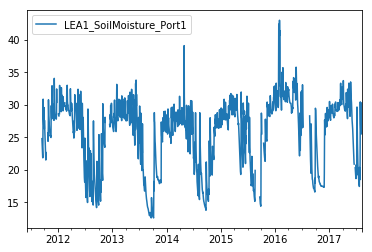

<Figure size 432x288 with 0 Axes>

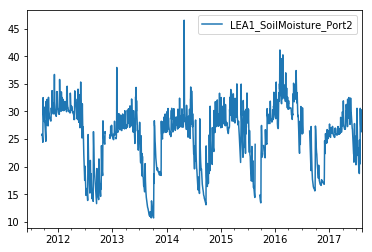

<Figure size 432x288 with 0 Axes>

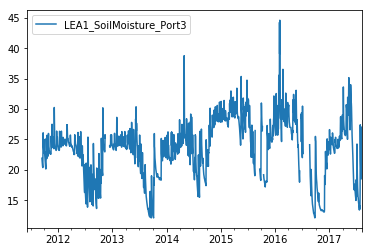

<Figure size 432x288 with 0 Axes>

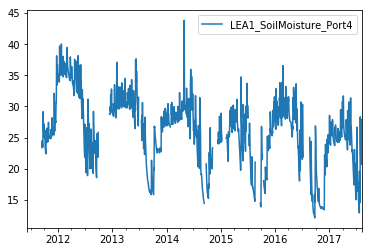

<Figure size 432x288 with 0 Axes>

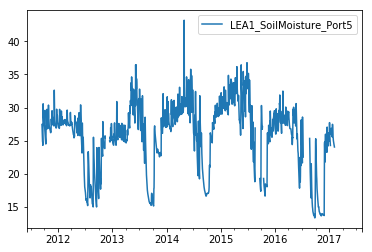

<Figure size 432x288 with 0 Axes>

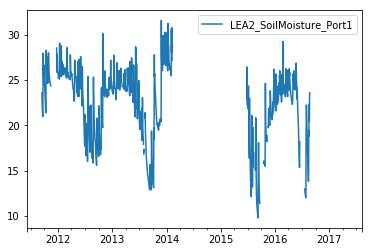

<Figure size 432x288 with 0 Axes>

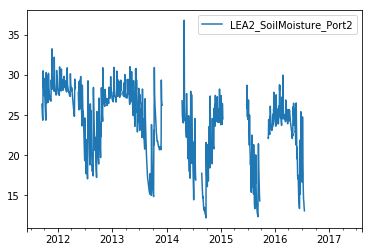

<Figure size 432x288 with 0 Axes>

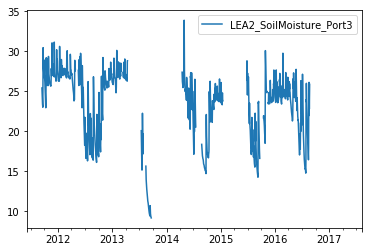

<Figure size 432x288 with 0 Axes>

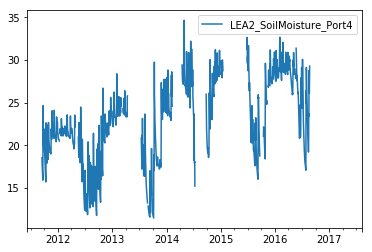

<Figure size 432x288 with 0 Axes>

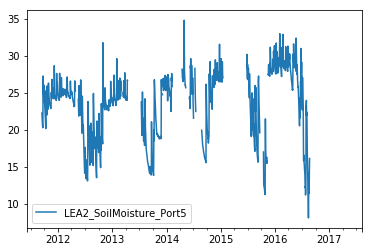

<Figure size 432x288 with 0 Axes>

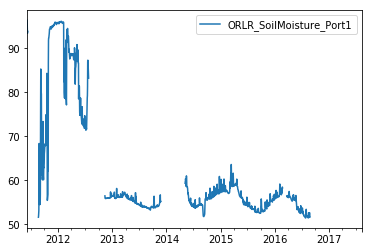

<Figure size 432x288 with 0 Axes>

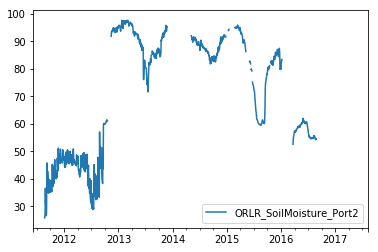

<Figure size 432x288 with 0 Axes>

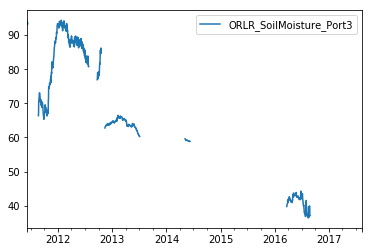

<Figure size 432x288 with 0 Axes>

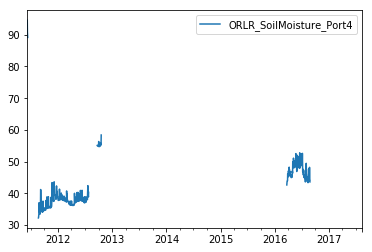

<Figure size 432x288 with 0 Axes>

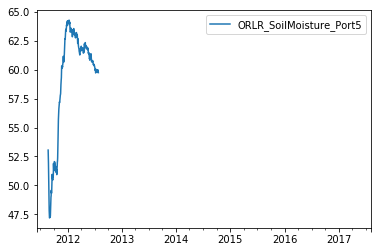

<Figure size 432x288 with 0 Axes>

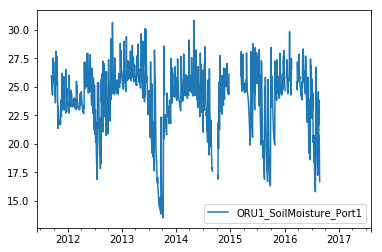

<Figure size 432x288 with 0 Axes>

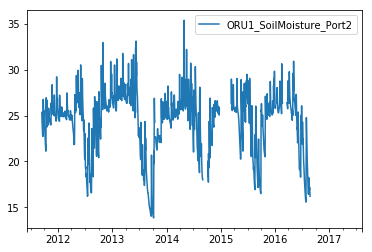

<Figure size 432x288 with 0 Axes>

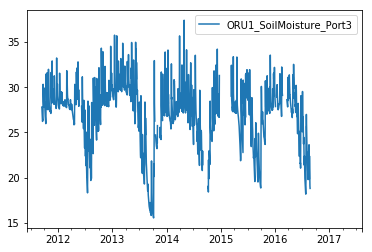

<Figure size 432x288 with 0 Axes>

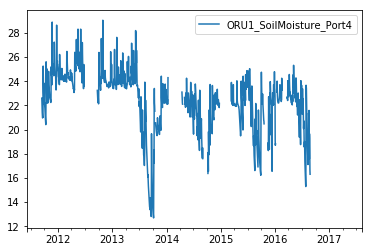

<Figure size 432x288 with 0 Axes>

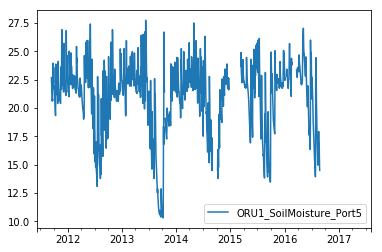

<Figure size 432x288 with 0 Axes>

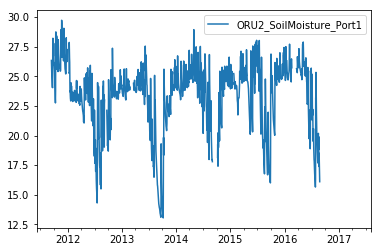

<Figure size 432x288 with 0 Axes>

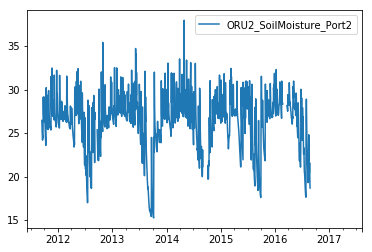

<Figure size 432x288 with 0 Axes>

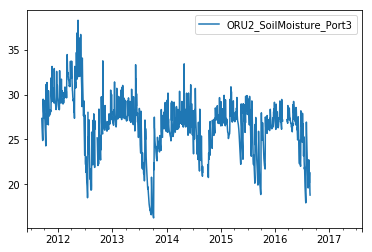

<Figure size 432x288 with 0 Axes>

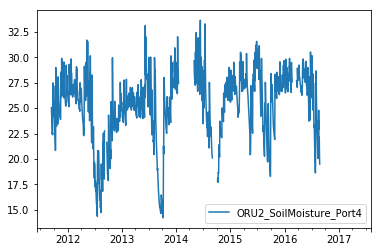

<Figure size 432x288 with 0 Axes>

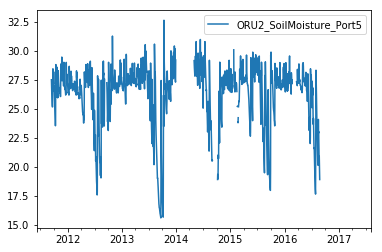

<Figure size 432x288 with 0 Axes>

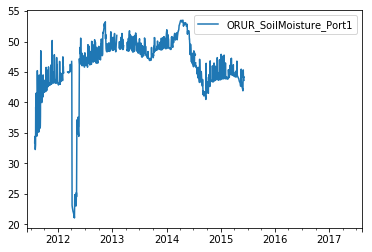

<Figure size 432x288 with 0 Axes>

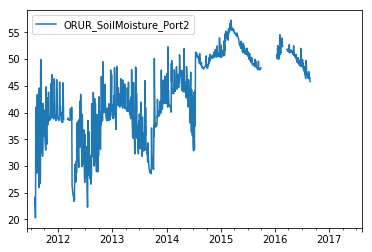

<Figure size 432x288 with 0 Axes>

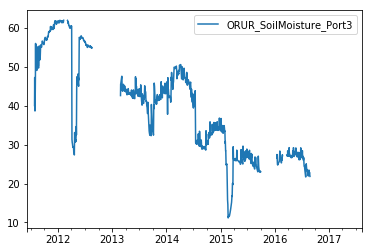

<Figure size 432x288 with 0 Axes>

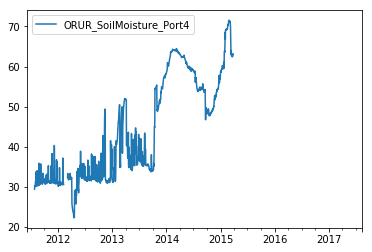

<Figure size 432x288 with 0 Axes>

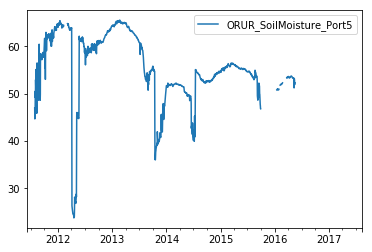

<Figure size 432x288 with 0 Axes>

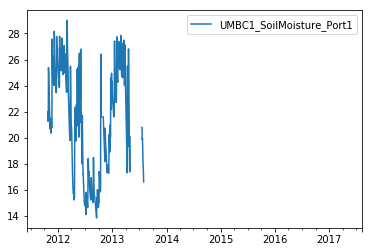

<Figure size 432x288 with 0 Axes>

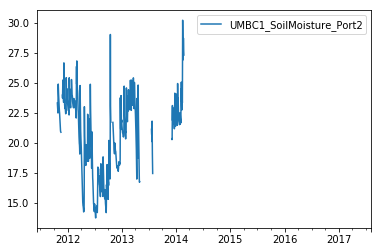

<Figure size 432x288 with 0 Axes>

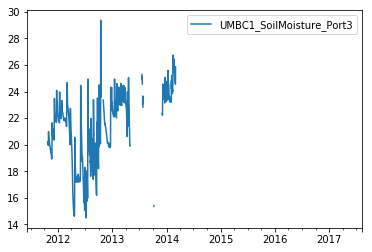

<Figure size 432x288 with 0 Axes>

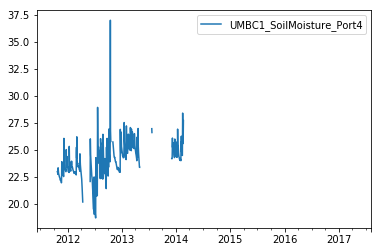

<Figure size 432x288 with 0 Axes>

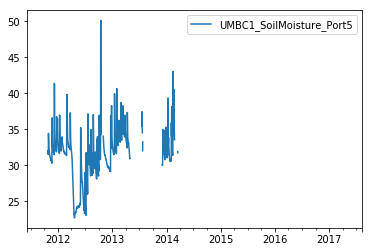

<Figure size 432x288 with 0 Axes>

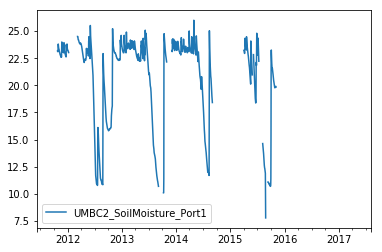

<Figure size 432x288 with 0 Axes>

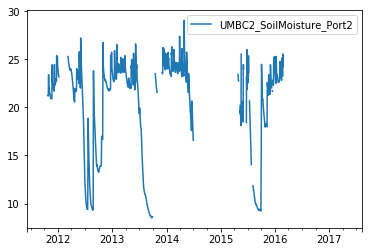

<Figure size 432x288 with 0 Axes>

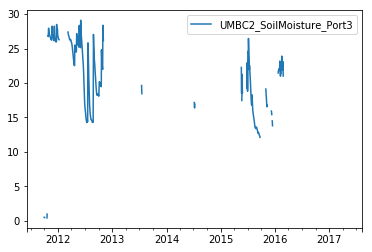

<Figure size 432x288 with 0 Axes>

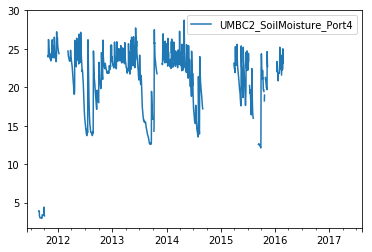

<Figure size 432x288 with 0 Axes>

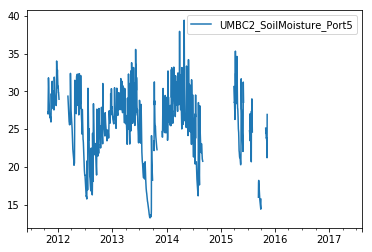

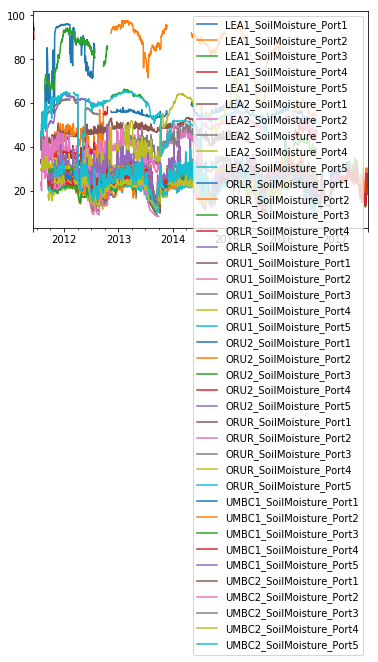

In [25]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilMositure data should be %
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100  # 
    plt.figure()
    df[[site]].plot()
SoilMoisture = copy.deepcopy(df)
SoilMoisture = threC(SoilMoisture,'SoilMoisture') 
SoilMoisture.plot()
SoilMoisture.head(2)

### 12. SoilTemperature

In [26]:
df_lst = []
port = ['Port1','Port2','Port3','Port4','Port5']
for site in data['Site'].unique():
    print(site)
    df = data[data['Site']==site]
    df = df.iloc[:,[3,7,11,15,19]]
    df.columns =[site + '_SoilTemperature_' + i for i in port]
    df = threC(df,'SoilTemperature')
    display(df.head())
    df_lst.append(df)
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean")

LEA1


LEA1_SoilTemperature_Port1  LEA1_SoilTemperature_Port2  \
DateTime                                                                      
2011-09-15 14:00:00                        20.2                        20.5   
2011-09-15 15:00:00                        20.1                        20.5   
2011-09-15 16:00:00                        20.1                        20.5   
2011-09-15 17:00:00                        20.0                        20.4   
2011-09-15 18:00:00                        19.8                        20.3   

                     LEA1_SoilTemperature_Port3  LEA1_SoilTemperature_Port4  \
DateTime                                                                      
2011-09-15 14:00:00                        20.7                        20.4   
2011-09-15 15:00:00                        20.7                        20.4   
2011-09-15 16:00:00                        20.7                        20.3   
2011-09-15 17:00:00                        20.6                        20.1   
2011-09-15 18:00:00                        20.4                        19.8   

                     LEA1_SoilTemperature_Port5  
DateTime                                         
2011-09-15 14:00:00                        20.6  
2011-09-15 15:00:00                        20.6  
2011-09-15 16:00:00                        20.5  
2011-09-15 17:00:00                        20.5  
2011-09-15 18:00:00                        20.3

LEA2


LEA2_SoilTemperature_Port1  LEA2_SoilTemperature_Port2  \
DateTime                                                                      
2011-09-15 13:00:00                        20.6                        20.5   
2011-09-15 14:00:00                        20.6                        20.5   
2011-09-15 15:00:00                        20.6                        20.5   
2011-09-15 16:00:00                        20.5                        20.5   
2011-09-15 17:00:00                        20.3                        20.3   

                     LEA2_SoilTemperature_Port3  LEA2_SoilTemperature_Port4  \
DateTime                                                                      
2011-09-15 13:00:00                        20.8                        20.9   
2011-09-15 14:00:00                        20.8                        20.9   
2011-09-15 15:00:00                        20.8                        20.9   
2011-09-15 16:00:00                        20.7                        20.7   
2011-09-15 17:00:00                        20.4                        20.5   

                     LEA2_SoilTemperature_Port5  
DateTime                                         
2011-09-15 13:00:00                        20.6  
2011-09-15 14:00:00                        20.6  
2011-09-15 15:00:00                        20.6  
2011-09-15 16:00:00                        20.5  
2011-09-15 17:00:00                        20.3

ORLR


ORLR_SoilTemperature_Port1  ORLR_SoilTemperature_Port2  \
DateTime                                                                      
2011-06-06 14:00:00                        24.2                        24.5   
2011-06-06 15:00:00                        23.7                        23.9   
2011-06-06 16:00:00                        23.1                        23.3   
2011-06-06 17:00:00                        22.8                        23.1   
2011-06-06 18:00:00                        22.6                        22.8   

                     ORLR_SoilTemperature_Port3  ORLR_SoilTemperature_Port4  \
DateTime                                                                      
2011-06-06 14:00:00                        24.3                        23.7   
2011-06-06 15:00:00                        23.6                        23.4   
2011-06-06 16:00:00                        23.1                        23.0   
2011-06-06 17:00:00                        22.8                        22.7   
2011-06-06 18:00:00                        22.6                        22.5   

                     ORLR_SoilTemperature_Port5  
DateTime                                         
2011-06-06 14:00:00                        23.9  
2011-06-06 15:00:00                        23.6  
2011-06-06 16:00:00                        23.2  
2011-06-06 17:00:00                        22.9  
2011-06-06 18:00:00                        22.7

ORU1


ORU1_SoilTemperature_Port1  ORU1_SoilTemperature_Port2  \
DateTime                                                                      
2011-09-14 11:00:00                        20.0                        20.2   
2011-09-14 12:00:00                        20.1                        20.4   
2011-09-14 13:00:00                        20.2                        20.5   
2011-09-14 14:00:00                        20.4                        20.7   
2011-09-14 15:00:00                        20.5                        20.9   

                     ORU1_SoilTemperature_Port3  ORU1_SoilTemperature_Port4  \
DateTime                                                                      
2011-09-14 11:00:00                        20.1                         NaN   
2011-09-14 12:00:00                        20.3                        20.3   
2011-09-14 13:00:00                        20.5                        20.5   
2011-09-14 14:00:00                        20.8                        20.8   
2011-09-14 15:00:00                        21.1                        20.9   

                     ORU1_SoilTemperature_Port5  
DateTime                                         
2011-09-14 11:00:00                        19.9  
2011-09-14 12:00:00                        20.1  
2011-09-14 13:00:00                        20.3  
2011-09-14 14:00:00                        20.5  
2011-09-14 15:00:00                        20.7

ORU2


ORU2_SoilTemperature_Port1  ORU2_SoilTemperature_Port2  \
DateTime                                                                      
2011-09-14 11:00:00                        20.3                        20.1   
2011-09-14 12:00:00                        20.6                        20.3   
2011-09-14 13:00:00                        20.8                        20.6   
2011-09-14 14:00:00                        21.1                        20.8   
2011-09-14 15:00:00                        21.3                        21.0   

                     ORU2_SoilTemperature_Port3  ORU2_SoilTemperature_Port4  \
DateTime                                                                      
2011-09-14 11:00:00                        20.1                        20.2   
2011-09-14 12:00:00                        20.4                        20.5   
2011-09-14 13:00:00                        20.6                        20.8   
2011-09-14 14:00:00                        20.8                        21.1   
2011-09-14 15:00:00                        21.0                        21.3   

                     ORU2_SoilTemperature_Port5  
DateTime                                         
2011-09-14 11:00:00                        20.6  
2011-09-14 12:00:00                        20.8  
2011-09-14 13:00:00                        21.1  
2011-09-14 14:00:00                        21.3  
2011-09-14 15:00:00                        21.6

ORUR


ORUR_SoilTemperature_Port1  ORUR_SoilTemperature_Port2  \
DateTime                                                                      
2011-07-28 12:00:00                        22.4                        24.3   
2011-07-28 13:00:00                        21.6                        22.2   
2011-07-28 14:00:00                        21.6                        22.2   
2011-07-28 15:00:00                        21.7                        22.2   
2011-07-28 16:00:00                        21.7                        22.3   

                     ORUR_SoilTemperature_Port3  ORUR_SoilTemperature_Port4  \
DateTime                                                                      
2011-07-28 12:00:00                        25.6                        26.3   
2011-07-28 13:00:00                        21.8                        20.7   
2011-07-28 14:00:00                        21.8                        21.9   
2011-07-28 15:00:00                        21.9                        22.0   
2011-07-28 16:00:00                        22.1                        22.1   

                     ORUR_SoilTemperature_Port5  
DateTime                                         
2011-07-28 12:00:00                        27.1  
2011-07-28 13:00:00                        20.1  
2011-07-28 14:00:00                        21.6  
2011-07-28 15:00:00                        21.6  
2011-07-28 16:00:00                        21.7

UMBC1


UMBC1_SoilTemperature_Port1  UMBC1_SoilTemperature_Port2  \
DateTime                                                                        
2011-10-24 13:00:00                         14.5                         14.9   
2011-10-24 14:00:00                         14.9                         15.0   
2011-10-24 15:00:00                         15.3                         15.2   
2011-10-24 16:00:00                         15.6                         15.4   
2011-10-24 17:00:00                         15.7                         15.6   

                     UMBC1_SoilTemperature_Port3  UMBC1_SoilTemperature_Port4  \
DateTime                                                                        
2011-10-24 13:00:00                         15.2                         15.8   
2011-10-24 14:00:00                         15.2                         15.8   
2011-10-24 15:00:00                         15.2                         15.8   
2011-10-24 16:00:00                         15.3                         15.8   
2011-10-24 17:00:00                         15.4                         15.8   

                     UMBC1_SoilTemperature_Port5  
DateTime                                          
2011-10-24 13:00:00                         16.7  
2011-10-24 14:00:00                         16.7  
2011-10-24 15:00:00                         16.7  
2011-10-24 16:00:00                         16.6  
2011-10-24 17:00:00                         16.6

UMBC2


UMBC2_SoilTemperature_Port1  UMBC2_SoilTemperature_Port2  \
DateTime                                                                        
2011-06-14 08:00:00                         21.9                         21.6   
2011-06-14 09:00:00                         22.2                         22.0   
2011-06-14 10:00:00                         22.2                         22.1   
2011-06-14 11:00:00                         22.2                         22.1   
2011-06-14 12:00:00                         22.1                         22.0   

                     UMBC2_SoilTemperature_Port3  UMBC2_SoilTemperature_Port4  \
DateTime                                                                        
2011-06-14 08:00:00                         21.9                         21.9   
2011-06-14 09:00:00                         22.2                         21.9   
2011-06-14 10:00:00                         22.3                         21.9   
2011-06-14 11:00:00                         22.3                         21.9   
2011-06-14 12:00:00                         22.3                         22.0   

                     UMBC2_SoilTemperature_Port5  
DateTime                                          
2011-06-14 08:00:00                         21.7  
2011-06-14 09:00:00                         22.2  
2011-06-14 10:00:00                         22.2  
2011-06-14 11:00:00                         22.2  
2011-06-14 12:00:00                         22.1

['LEA1_SoilTemperature_Port1', datetime.date(2013, 7, 31)]
nan ratio is 0.041666666666666664 , groupby value is 20.241304347826084
['LEA1_SoilTemperature_Port1', datetime.date(2013, 8, 4)]
nan ratio is 0.041666666666666664 , groupby value is 19.895652173913028
['LEA1_SoilTemperature_Port4', datetime.date(2013, 6, 23)]
nan ratio is 0.020833333333333332 , groupby value is 19.67446808510638
['LEA1_SoilTemperature_Port4', datetime.date(2014, 9, 12)]
nan ratio is 0.08333333333333333 , groupby value is 20.529545454545456
['LEA2_SoilTemperature_Port1', datetime.date(2012, 1, 11)]
nan ratio is 0.08333333333333333 , groupby value is 4.7727272727272725
['LEA2_SoilTemperature_Port1', datetime.date(2014, 8, 26)]
nan ratio is 0.042105263157894736 , groupby value is 20.45494505494506
['LEA2_SoilTemperature_Port2', datetime.date(2014, 8, 26)]
nan ratio is 0.042105263157894736 , groupby value is 20.282417582417594
['LEA2_SoilTemperature_Port3', datetime.date(2013, 3, 14)]
nan ratio is 0.03571428571428

['ORUR_SoilTemperature_Port5', datetime.date(2014, 5, 20)]
nan ratio is 0.041666666666666664 , groupby value is 13.25652173913043
['ORUR_SoilTemperature_Port5', datetime.date(2014, 7, 15)]
nan ratio is 0.041666666666666664 , groupby value is 20.326086956521742
['ORUR_SoilTemperature_Port5', datetime.date(2016, 1, 31)]
nan ratio is 0.08333333333333333 , groupby value is 3.0954545454545466
['ORUR_SoilTemperature_Port5', datetime.date(2016, 2, 6)]
nan ratio is 0.08333333333333333 , groupby value is 3.0454545454545463
['ORUR_SoilTemperature_Port5', datetime.date(2016, 5, 10)]
nan ratio is 0.041666666666666664 , groupby value is 12.969565217391304
['ORUR_SoilTemperature_Port5', datetime.date(2016, 5, 13)]
nan ratio is 0.08333333333333333 , groupby value is 13.149999999999999
['ORUR_SoilTemperature_Port5', datetime.date(2016, 5, 14)]
nan ratio is 0.08333333333333333 , groupby value is 11.345454545454544
['ORUR_SoilTemperature_Port5', datetime.date(2016, 5, 15)]
nan ratio is 0.083333333333333

LEA1_SoilTemperature_Port1 LEA1_SoilTemperature_Port2  \
2011-06-06                        NaN                        NaN   
2011-06-07                        NaN                        NaN   

           LEA1_SoilTemperature_Port3 LEA1_SoilTemperature_Port4  \
2011-06-06                        NaN                        NaN   
2011-06-07                        NaN                        NaN   

           LEA1_SoilTemperature_Port5 LEA2_SoilTemperature_Port1  \
2011-06-06                        NaN                        NaN   
2011-06-07                        NaN                        NaN   

           LEA2_SoilTemperature_Port2 LEA2_SoilTemperature_Port3  \
2011-06-06                        NaN                        NaN   
2011-06-07                        NaN                        NaN   

           LEA2_SoilTemperature_Port4 LEA2_SoilTemperature_Port5  ...  \
2011-06-06                        NaN                        NaN  ...   
2011-06-07                        NaN                        NaN  ...   

           UMBC1_SoilTemperature_Port1 UMBC1_SoilTemperature_Port2  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

           UMBC1_SoilTemperature_Port3 UMBC1_SoilTemperature_Port4  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

           UMBC1_SoilTemperature_Port5 UMBC2_SoilTemperature_Port1  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

           UMBC2_SoilTemperature_Port2 UMBC2_SoilTemperature_Port3  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

           UMBC2_SoilTemperature_Port4 UMBC2_SoilTemperature_Port5  
2011-06-06                         NaN                         NaN  
2011-06-07                         NaN                         NaN  

[2 rows x 40 columns]

LEA1_SoilTemperature_Port1 LEA1_SoilTemperature_Port2  \
2017-08-07                    20.9542                    20.5375   
2017-08-08                    20.9818                    20.5545   

           LEA1_SoilTemperature_Port3 LEA1_SoilTemperature_Port4  \
2017-08-07                    20.6917                        NaN   
2017-08-08                    20.6727                        NaN   

           LEA1_SoilTemperature_Port5 LEA2_SoilTemperature_Port1  \
2017-08-07                        NaN                        NaN   
2017-08-08                        NaN                        NaN   

           LEA2_SoilTemperature_Port2 LEA2_SoilTemperature_Port3  \
2017-08-07                        NaN                        NaN   
2017-08-08                        NaN                        NaN   

           LEA2_SoilTemperature_Port4 LEA2_SoilTemperature_Port5  ...  \
2017-08-07                        NaN                        NaN  ...   
2017-08-08                        NaN                        NaN  ...   

           UMBC1_SoilTemperature_Port1 UMBC1_SoilTemperature_Port2  \
2017-08-07                         NaN                         NaN   
2017-08-08                         NaN                         NaN   

           UMBC1_SoilTemperature_Port3 UMBC1_SoilTemperature_Port4  \
2017-08-07                         NaN                         NaN   
2017-08-08                         NaN                         NaN   

           UMBC1_SoilTemperature_Port5 UMBC2_SoilTemperature_Port1  \
2017-08-07                         NaN                         NaN   
2017-08-08                         NaN                         NaN   

           UMBC2_SoilTemperature_Port2 UMBC2_SoilTemperature_Port3  \
2017-08-07                         NaN                         NaN   
2017-08-08                         NaN                         NaN   

           UMBC2_SoilTemperature_Port4 UMBC2_SoilTemperature_Port5  
2017-08-07                         NaN                         NaN  
2017-08-08                         NaN                         NaN  

[2 rows x 40 columns]

LEA1_SoilTemperature_Port1
LEA1_SoilTemperature_Port2
LEA1_SoilTemperature_Port3
LEA1_SoilTemperature_Port4
LEA1_SoilTemperature_Port5
LEA2_SoilTemperature_Port1
LEA2_SoilTemperature_Port2
LEA2_SoilTemperature_Port3
LEA2_SoilTemperature_Port4
LEA2_SoilTemperature_Port5
ORLR_SoilTemperature_Port1
ORLR_SoilTemperature_Port2
ORLR_SoilTemperature_Port3
ORLR_SoilTemperature_Port4
ORLR_SoilTemperature_Port5
ORU1_SoilTemperature_Port1
ORU1_SoilTemperature_Port2
ORU1_SoilTemperature_Port3
ORU1_SoilTemperature_Port4
ORU1_SoilTemperature_Port5
ORU2_SoilTemperature_Port1
ORU2_SoilTemperature_Port2
ORU2_SoilTemperature_Port3
ORU2_SoilTemperature_Port4
ORU2_SoilTemperature_Port5
ORUR_SoilTemperature_Port1
ORUR_SoilTemperature_Port2
ORUR_SoilTemperature_Port3
ORUR_SoilTemperature_Port4
ORUR_SoilTemperature_Port5
UMBC1_SoilTemperature_Port1
UMBC1_SoilTemperature_Port2
UMBC1_SoilTemperature_Port3
UMBC1_SoilTemperature_Port4
UMBC1_SoilTemperature_Port5
UMBC2_SoilTemperature_Port1
UMBC2_SoilTemperature_

LEA1_SoilTemperature_Port1  LEA1_SoilTemperature_Port2  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

            LEA1_SoilTemperature_Port3  LEA1_SoilTemperature_Port4  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

            LEA1_SoilTemperature_Port5  LEA2_SoilTemperature_Port1  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

            LEA2_SoilTemperature_Port2  LEA2_SoilTemperature_Port3  \
2011-06-06                         NaN                         NaN   
2011-06-07                         NaN                         NaN   

            LEA2_SoilTemperature_Port4  LEA2_SoilTemperature_Port5  ...  \
2011-06-06                         NaN                         NaN  ...   
2011-06-07                         NaN                         NaN  ...   

            UMBC1_SoilTemperature_Port1  UMBC1_SoilTemperature_Port2  \
2011-06-06                          NaN                          NaN   
2011-06-07                          NaN                          NaN   

            UMBC1_SoilTemperature_Port3  UMBC1_SoilTemperature_Port4  \
2011-06-06                          NaN                          NaN   
2011-06-07                          NaN                          NaN   

            UMBC1_SoilTemperature_Port5  UMBC2_SoilTemperature_Port1  \
2011-06-06                          NaN                          NaN   
2011-06-07                          NaN                          NaN   

            UMBC2_SoilTemperature_Port2  UMBC2_SoilTemperature_Port3  \
2011-06-06                          NaN                          NaN   
2011-06-07                          NaN                          NaN   

            UMBC2_SoilTemperature_Port4  UMBC2_SoilTemperature_Port5  
2011-06-06                          NaN                          NaN  
2011-06-07                          NaN                          NaN  

[2 rows x 40 columns]

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

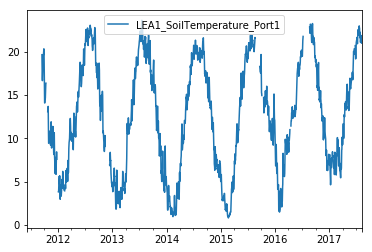

<Figure size 432x288 with 0 Axes>

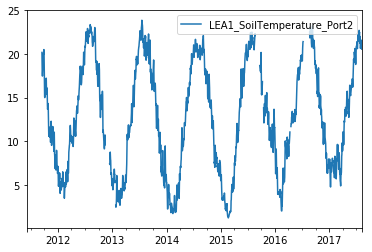

<Figure size 432x288 with 0 Axes>

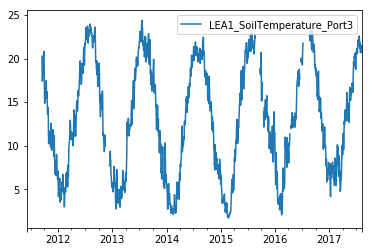

<Figure size 432x288 with 0 Axes>

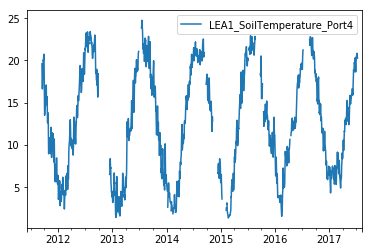

<Figure size 432x288 with 0 Axes>

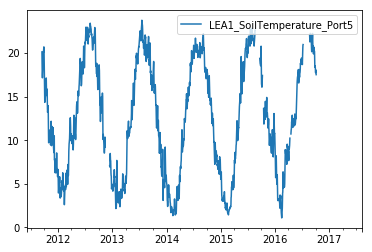

<Figure size 432x288 with 0 Axes>

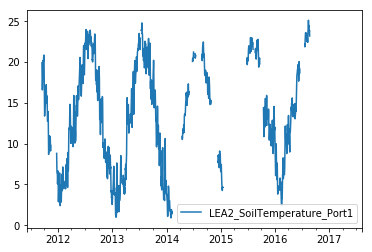

<Figure size 432x288 with 0 Axes>

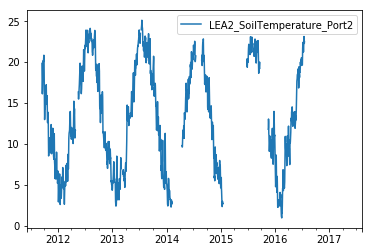

<Figure size 432x288 with 0 Axes>

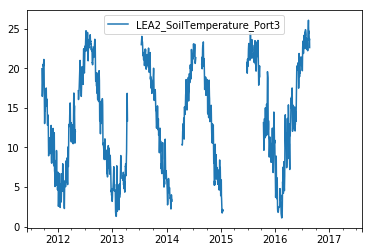

<Figure size 432x288 with 0 Axes>

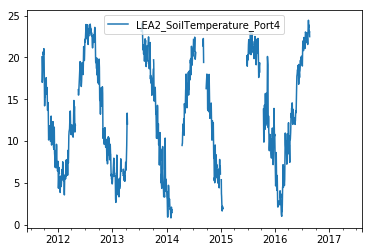

<Figure size 432x288 with 0 Axes>

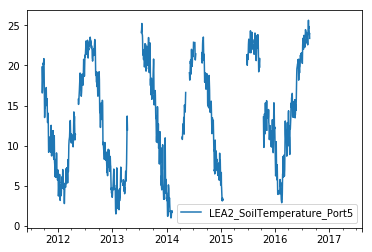

<Figure size 432x288 with 0 Axes>

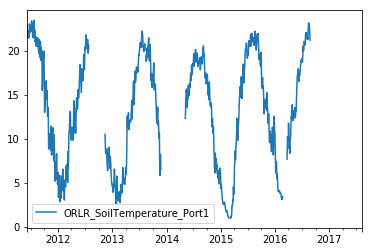

<Figure size 432x288 with 0 Axes>

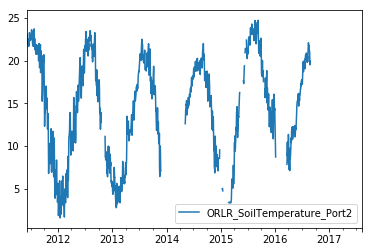

<Figure size 432x288 with 0 Axes>

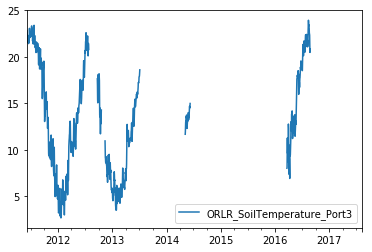

<Figure size 432x288 with 0 Axes>

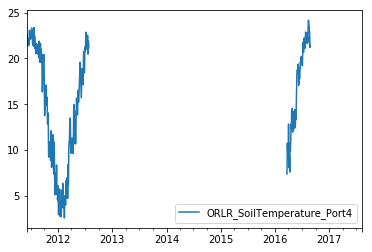

<Figure size 432x288 with 0 Axes>

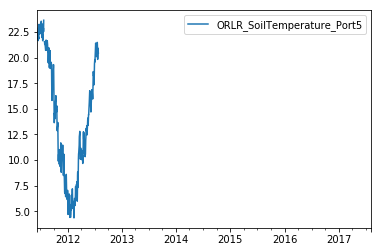

<Figure size 432x288 with 0 Axes>

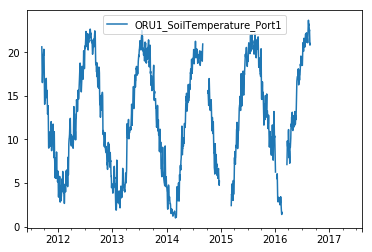

<Figure size 432x288 with 0 Axes>

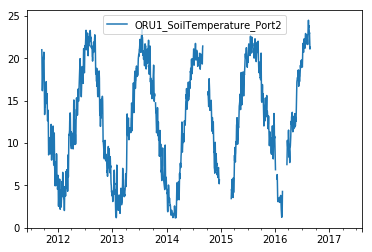

<Figure size 432x288 with 0 Axes>

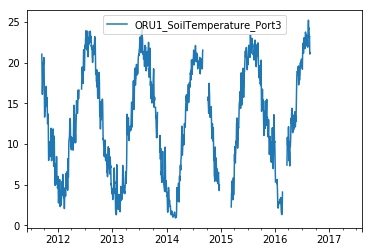

<Figure size 432x288 with 0 Axes>

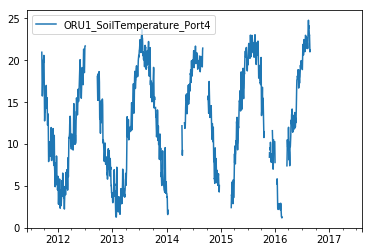

<Figure size 432x288 with 0 Axes>

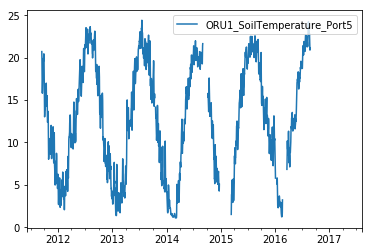

<Figure size 432x288 with 0 Axes>

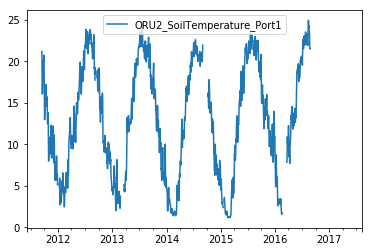

<Figure size 432x288 with 0 Axes>

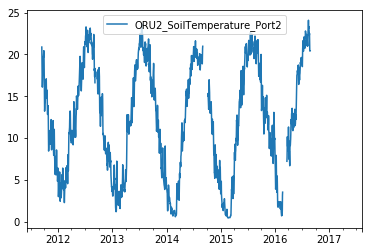

<Figure size 432x288 with 0 Axes>

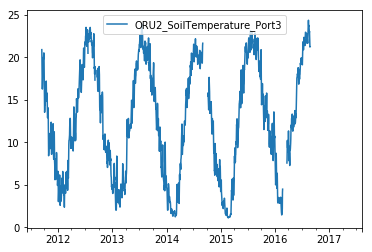

<Figure size 432x288 with 0 Axes>

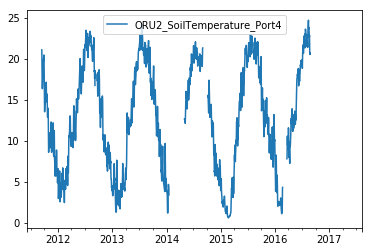

<Figure size 432x288 with 0 Axes>

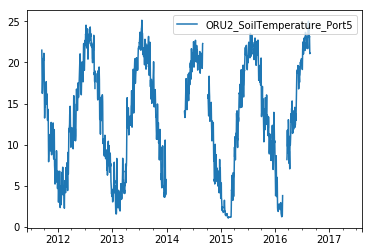

<Figure size 432x288 with 0 Axes>

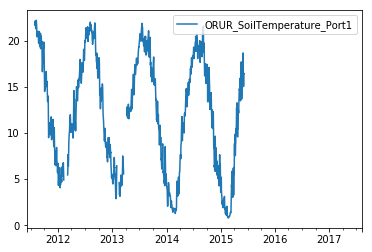

<Figure size 432x288 with 0 Axes>

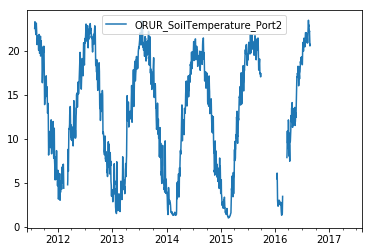

<Figure size 432x288 with 0 Axes>

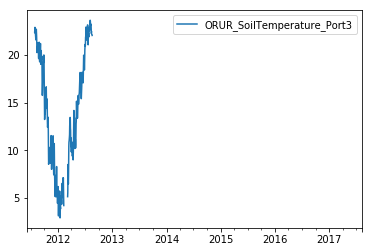

<Figure size 432x288 with 0 Axes>

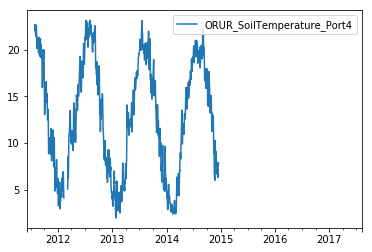

<Figure size 432x288 with 0 Axes>

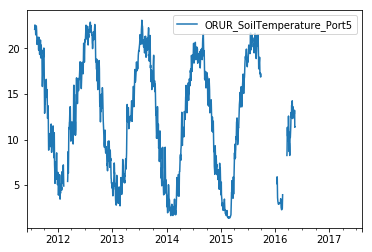

<Figure size 432x288 with 0 Axes>

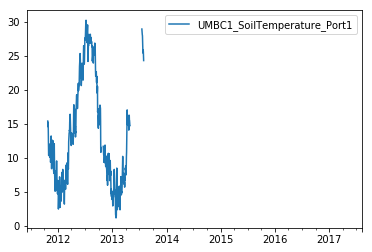

<Figure size 432x288 with 0 Axes>

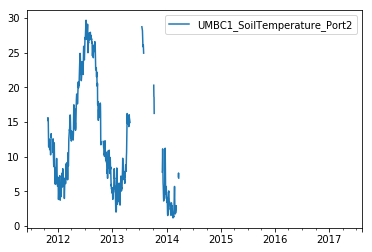

<Figure size 432x288 with 0 Axes>

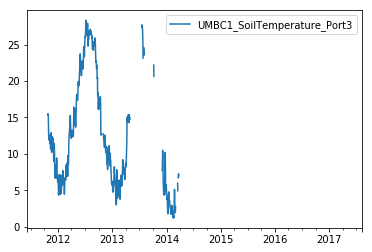

<Figure size 432x288 with 0 Axes>

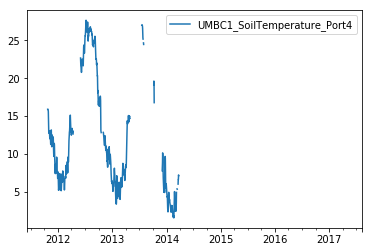

<Figure size 432x288 with 0 Axes>

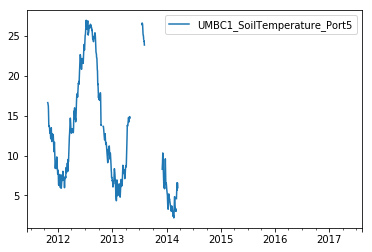

<Figure size 432x288 with 0 Axes>

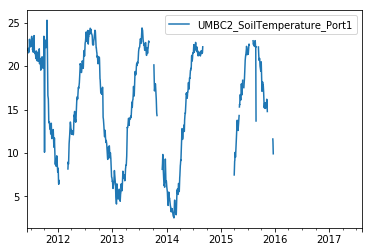

<Figure size 432x288 with 0 Axes>

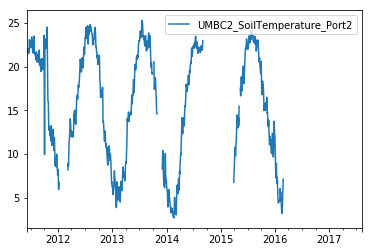

<Figure size 432x288 with 0 Axes>

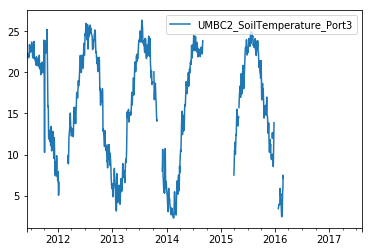

<Figure size 432x288 with 0 Axes>

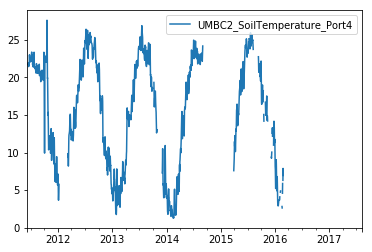

<Figure size 432x288 with 0 Axes>

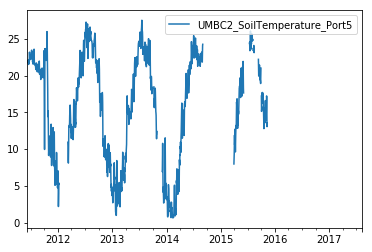

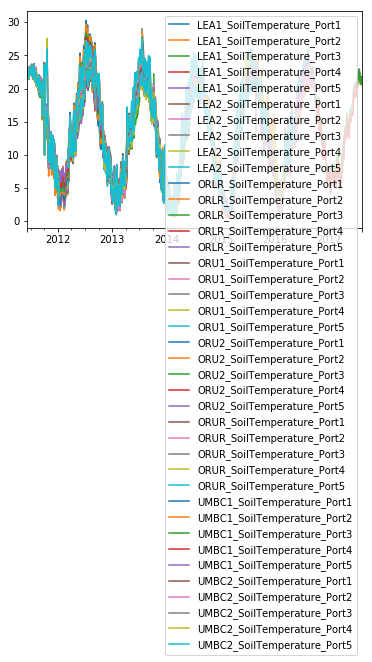

In [27]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilTemperature data should be degree celsius
# change the start and end date/hour to the longest record start and end date/
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # 
    plt.figure()
    df[[site]].plot()
    
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()
SoilTemperature.head(2)

### 13. Isotope

In [28]:
# Link: https://portal.lternet.edu/nis/mapbrowse?packageid=knb-lter-bes.609.130
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-bes.609.130&entityid=c80c62ec05bad25b8505dcdcd60df191',
                    header = None, parse_dates = True, infer_datetime_format = True, sep = '\t',skiprows = 1)
data.head(5)

0           1      2     3         4   5   6   7   8   9   10
0  BARN  11/18/2003   7.61  3.18  1.782324 NaN NaN NaN NaN NaN NaN
1  BARN  02/24/2004  10.57  3.57  0.813990 NaN NaN NaN NaN NaN NaN
2  BARN  07/06/2005   6.57  0.39  1.354780 NaN NaN NaN NaN NaN NaN
3  BARN  07/12/2005   6.66  0.49  0.761530 NaN NaN NaN NaN NaN NaN
4  BARN  07/19/2005   7.10  0.23  1.067850 NaN NaN NaN NaN NaN NaN

In [29]:
data.columns = ['Site Name','Date Collected','Isotope_d15N-NO3','Isotope_d18O-NO3',
                'NO3-(mg/L)', 'd15N-POM', 'd13C-POM',7,8,9,10]
data.index = data['Date Collected']
data = copy.deepcopy(data[['Site Name','Isotope_d15N-NO3','Isotope_d18O-NO3']])
data['Site Name'] = [i.replace(' ','') for i in data['Site Name']]
data.sort_index().head()

Site Name  Isotope_d15N-NO3  Isotope_d18O-NO3
Date Collected                                              
 2/16/2004       UMBC2#2              0.49             36.40
02/24/2004          GFGL             12.85              5.85
02/24/2004          POBR             22.22             48.38
02/24/2004          BARN             10.57              3.57
07/06/2005          GFGL             12.97              3.41

In [30]:
def pivot(df, id_col='SITECODE', source='discharge', col1 = '', col2 = ''):
    df.index = pd.to_datetime(df.index)
    result = pd.DataFrame()
    for i, site in enumerate(df[id_col].unique()):
        #print(i)
        #print(site)
        df_H = copy.deepcopy(df[df[id_col]==site][[col1]])
        df_H = df_H.groupby(df_H.index.date).mean()
        df_O = copy.deepcopy(df[df[id_col]==site][[col2]])
        df_O = df_O.groupby(df_O.index.date).mean()
        #display(df_H.shape)
        #site_name = site.replace(' ','')
        #site_name = site_name.replace('#','')
        #site_name = site_name.replace('_','')
        #site_name = site_name.replace('.','')
        site_name = site
        df_H.columns = [site_name + '_' + col1 + '_' + source]
        df_O.columns = [site_name + '_' + col2 + '_' + source]
        result = copy.deepcopy(result.join(df_H, how = 'outer'))
        result = copy.deepcopy(result.join(df_O, how = 'outer'))
    display(result.head(3))
    return result

In [31]:
prep1 = pivot(data,'Site Name','discharge','Isotope_d15N-NO3','Isotope_d18O-NO3')

BARN_Isotope_d15N-NO3_discharge  BARN_Isotope_d18O-NO3_discharge  \
2003-11-18                             7.61                             3.18   
2003-12-19                              NaN                              NaN   
2004-02-16                              NaN                              NaN   

            DRKR_Isotope_d15N-NO3_discharge  DRKR_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2003-12-19                              NaN                              NaN   
2004-02-16                              NaN                              NaN   

            GFCP_Isotope_d15N-NO3_discharge  GFCP_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2003-12-19                              NaN                              NaN   
2004-02-16                              NaN                              NaN   

            GFGL_Isotope_d15N-NO3_discharge  GFGL_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2003-12-19                              NaN                              NaN   
2004-02-16                              NaN                              NaN   

            GFGR_Isotope_d15N-NO3_discharge  GFGR_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2003-12-19                              NaN                              NaN   
2004-02-16                              NaN                              NaN   

            ...  DR1_Isotope_d15N-NO3_discharge  \
2003-11-18  ...                             NaN   
2003-12-19  ...                             NaN   
2004-02-16  ...                             NaN   

            DR1_Isotope_d18O-NO3_discharge  DR3.1_Isotope_d15N-NO3_discharge  \
2003-11-18                             NaN                               NaN   
2003-12-19                             NaN                               NaN   
2004-02-16                             NaN                               NaN   

            DR3.1_Isotope_d18O-NO3_discharge  \
2003-11-18                               NaN   
2003-12-19                               NaN   
2004-02-16                               NaN   

            DR3.2_Isotope_d15N-NO3_discharge  \
2003-11-18                               NaN   
2003-12-19                               NaN   
2004-02-16                               NaN   

            DR3.2_Isotope_d18O-NO3_discharge  DR4_Isotope_d15N-NO3_discharge  \
2003-11-18                               NaN                             NaN   
2003-12-19                               NaN                             NaN   
2004-02-16                               NaN                             NaN   

            DR4_Isotope_d18O-NO3_discharge  DR5_Isotope_d15N-NO3_discharge  \
2003-11-18                             NaN                             NaN   
2003-12-19                             NaN                             NaN   
2004-02-16                             NaN                             NaN   

            DR5_Isotope_d18O-NO3_discharge  
2003-11-18                             NaN  
2003-12-19                             NaN  
2004-02-16                             NaN  

[3 rows x 34 columns]

In [32]:
prep1.shape == prep1.dropna(how='all').shape

True

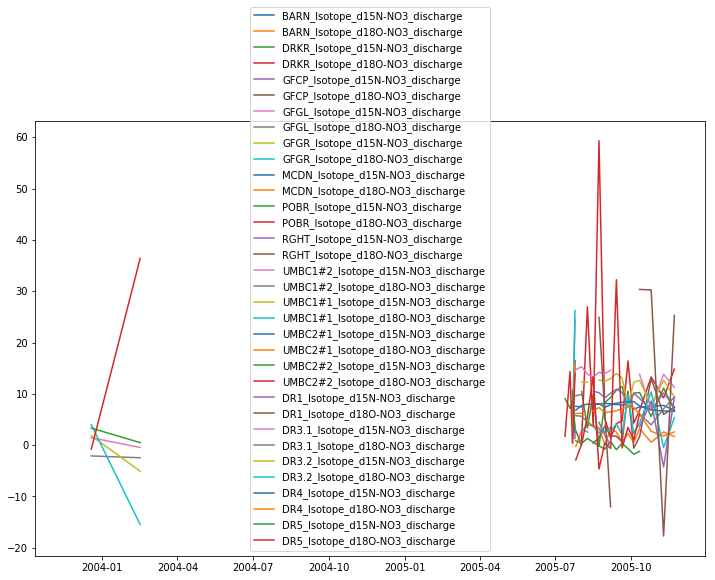

In [33]:
prep1.plot(figsize = (12,8))

In [34]:
# https://portal.lternet.edu/nis/mapbrowse?packageid=knb-lter-bes.700.600
data = pd.read_csv('https://portal.lternet.edu/nis/dataviewer?packageid=knb-lter-bes.700.600&entityid=bc597cc2f280ce7713c8134b89f79f6c',
                    header = None, parse_dates = True, infer_datetime_format = True, sep = ',',skiprows = 40)
data.head(5)

0     1    2     3       4     5     6      7  8  9   ... 29 30 31  \
0  15-Oct-98  1998  288  GFCP   33.47  1.12  24.2  20.74  .  .  ...  .  .  .   
1  15-Oct-98  1998  288  GFGB   21.48  1.66     4   4.54  .  .  ...  .  .  .   
2  15-Oct-98  1998  288  GFGL  109.68  2.71  70.9   30.8  .  .  ...  .  .  .   
3  15-Oct-98  1998  288  GFVN   34.13  1.27  11.3  10.37  .  .  ...  .  .  .   
4  15-Oct-98  1998  288  POBR     2.5  0.01   2.2   0.82  .  .  ...  .  .  .   

  32 33     34      35    36     37     38  
0  .  .      .       .     .      .      .  
1  .  .  14.12   32.02  1.50   5.69   7.58  
2  .  .  49.27  111.74  2.38  41.75  25.72  
3  .  .      .       .     .      .      .  
4  .  .   0.73    9.91  0.99   0.61   2.20  

[5 rows x 39 columns]

In [35]:
data = data[[0,3,32,33]]

data[33] = [np.nan if i=='.' else i for i in data[33] ]
data[32] = [np.nan if i=='.' else i for i in data[32] ]
data.columns = ['Date','Site','Isotope_d15N-NO3','Isotope_d18O-NO3']
data['Isotope_d15N-NO3'] =  pd.to_numeric(data['Isotope_d15N-NO3'], errors = 'coerce')
data['Isotope_d18O-NO3'] =  pd.to_numeric(data['Isotope_d18O-NO3'], errors = 'coerce')
data['Site'] = [i.upper() for i in data['Site']]
data.index = data['Date']
data.drop(columns = {'Date'}, inplace = True)
data.dropna(how = 'all',subset=['Isotope_d15N-NO3','Isotope_d18O-NO3'], inplace = True)
data.head()

Site  Isotope_d15N-NO3  Isotope_d18O-NO3
Date                                               
18-Nov-03  BARN          7.613066          3.177773
24-Feb-04  BARN         10.571550          3.565323
24-Feb-04  GFGL         12.846707          5.845735
24-Feb-04  POBR         22.220000         48.379529
6-Jul-05   BARN          6.565000          0.390000

In [36]:
prep2 = pivot(data,'Site','discharge','Isotope_d15N-NO3','Isotope_d18O-NO3')

BARN_Isotope_d15N-NO3_discharge  BARN_Isotope_d18O-NO3_discharge  \
2003-11-18                         7.613066                         3.177773   
2004-02-24                        10.571550                         3.565323   
2005-07-06                         6.565000                         0.390000   

            GFGL_Isotope_d15N-NO3_discharge  GFGL_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                        12.846707                         5.845735   
2005-07-06                        12.970000                         3.413320   

            POBR_Isotope_d15N-NO3_discharge  POBR_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                            22.22                        48.379529   
2005-07-06                           -12.86                        -7.451038   

            GFCP_Isotope_d15N-NO3_discharge  GFCP_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                              NaN                              NaN   
2005-07-06                            7.525                        12.977887   

            MCDN_Isotope_d15N-NO3_discharge  MCDN_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                              NaN                              NaN   
2005-07-06                         7.671991                         5.422806   

            ...  GFUGR_Isotope_d15N-NO3_discharge  \
2003-11-18  ...                               NaN   
2004-02-24  ...                               NaN   
2005-07-06  ...                               NaN   

            GFUGR_Isotope_d18O-NO3_discharge  GRGF_Isotope_d15N-NO3_discharge  \
2003-11-18                               NaN                              NaN   
2004-02-24                               NaN                              NaN   
2005-07-06                               NaN                              NaN   

            GRGF_Isotope_d18O-NO3_discharge  RGHT_Isotope_d15N-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                              NaN                              NaN   
2005-07-06                              NaN                              NaN   

            RGHT_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN   
2004-02-24                              NaN   
2005-07-06                              NaN   

            RGHTISCO_Isotope_d15N-NO3_discharge  \
2003-11-18                                  NaN   
2004-02-24                                  NaN   
2005-07-06                                  NaN   

            RGHTISCO_Isotope_d18O-NO3_discharge  \
2003-11-18                                  NaN   
2004-02-24                                  NaN   
2005-07-06                                  NaN   

            GFGR_Isotope_d15N-NO3_discharge  GFGR_Isotope_d18O-NO3_discharge  
2003-11-18                              NaN                              NaN  
2004-02-24                              NaN                              NaN  
2005-07-06                              NaN                              NaN  

[3 rows x 22 columns]

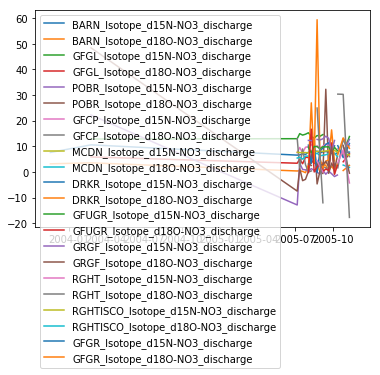

In [37]:
prep2.plot()

In [38]:
#Isotope = copy.deepcopy(pd.concat([prep1,prep2] , sort = True))
Isotope = copy.deepcopy(prep2)

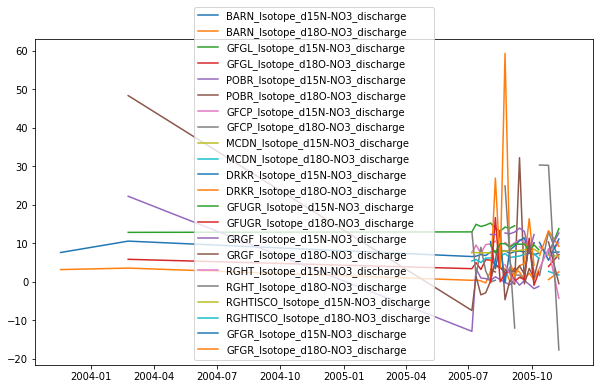

In [39]:
Isotope.plot(figsize = (10,6))

In [40]:
Isotope.head()

BARN_Isotope_d15N-NO3_discharge  BARN_Isotope_d18O-NO3_discharge  \
2003-11-18                         7.613066                         3.177773   
2004-02-24                        10.571550                         3.565323   
2005-07-06                         6.565000                         0.390000   
2005-07-12                         6.655000                         0.490000   
2005-07-19                         7.100000                         0.225000   

            GFGL_Isotope_d15N-NO3_discharge  GFGL_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                        12.846707                         5.845735   
2005-07-06                        12.970000                         3.413320   
2005-07-12                        14.944557                         4.964485   
2005-07-19                        14.370000                         3.210000   

            POBR_Isotope_d15N-NO3_discharge  POBR_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                            22.22                        48.379529   
2005-07-06                           -12.86                        -7.451038   
2005-07-12                             3.44                         1.436648   
2005-07-19                             0.99                        -3.384973   

            GFCP_Isotope_d15N-NO3_discharge  GFCP_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                              NaN                              NaN   
2005-07-06                            7.525                        12.977887   
2005-07-12                            9.550                         1.600000   
2005-07-19                            7.470                         8.990000   

            MCDN_Isotope_d15N-NO3_discharge  MCDN_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                              NaN                              NaN   
2005-07-06                         7.671991                         5.422806   
2005-07-12                         7.560861                         5.794385   
2005-07-19                         7.567737                         4.990669   

            ...  GFUGR_Isotope_d15N-NO3_discharge  \
2003-11-18  ...                               NaN   
2004-02-24  ...                               NaN   
2005-07-06  ...                               NaN   
2005-07-12  ...                               NaN   
2005-07-19  ...                              6.46   

            GFUGR_Isotope_d18O-NO3_discharge  GRGF_Isotope_d15N-NO3_discharge  \
2003-11-18                               NaN                              NaN   
2004-02-24                               NaN                              NaN   
2005-07-06                               NaN                              NaN   
2005-07-12                               NaN                              NaN   
2005-07-19                               0.0                        12.250321   

            GRGF_Isotope_d18O-NO3_discharge  RGHT_Isotope_d15N-NO3_discharge  \
2003-11-18                              NaN                              NaN   
2004-02-24                              NaN                              NaN   
2005-07-06                              NaN                              NaN   
2005-07-12                              NaN                              NaN   
2005-07-19                         3.368324                              NaN   

            RGHT_Isotope_d18O-NO3_discharge  \
2003-11-18                              NaN   
2004-02-24                              NaN   
2005-07-06                              NaN   
2005-07-12                              NaN   
2005-07-19                              NaN   

            RGHTISCO_Isotope_d15N-NO3

In [41]:
Isotope = Isotope.iloc[2:,:]

### Combine everything

In [64]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S

# Bring them together
result= pd.concat([Discharge,Precipitation,SoilMoisture,SoilTemperature],
                  axis=1,join='outer')
result.index.rename('DateTime',inplace = True)
result.head()

GWYNNS_Discharge  Carrie_Precipitation  Carroll_Precipitation  \
DateTime                                                                    
2005-01-01           1188.60                   NaN                    NaN   
2005-01-02           1188.60                   NaN                    NaN   
2005-01-03           1188.60                   NaN                    NaN   
2005-01-04           1202.75                   NaN                    NaN   
2005-01-05           2999.80                   NaN                    NaN   

            DeadRun_Precipitation  Glyndon_Precipitation  \
DateTime                                                   
2005-01-01                    NaN                    NaN   
2005-01-02                    NaN                    NaN   
2005-01-03                    NaN                    NaN   
2005-01-04                    NaN                    NaN   
2005-01-05                    NaN                    NaN   

            Gwynns_Precipitation  McDonogh_Precipitation  \
DateTime                                                   
2005-01-01                   NaN                     NaN   
2005-01-02                   NaN                     NaN   
2005-01-03                   NaN                     NaN   
2005-01-04                   NaN                     NaN   
2005-01-05                   NaN                     NaN   

            Oregon_Precipitation  UMBC_Precipitation  LEA1_SoilMoisture_Port1  \
DateTime                                                                        
2005-01-01                   NaN                 NaN                      NaN   
2005-01-02                   NaN                 NaN                      NaN   
2005-01-03                   NaN                 NaN                      NaN   
2005-01-04                   NaN                 NaN                      NaN   
2005-01-05                   NaN                 NaN                      NaN   

            ...  UMBC1_SoilTemperature_Port1  UMBC1_SoilTemperature_Port2  \
DateTime    ...                                                             
2005-01-01  ...                          NaN                          NaN   
2005-01-02  ...                          NaN                          NaN   
2005-01-03  ...                          NaN                          NaN   
2005-01-04  ...                          NaN                          NaN   
2005-01-05  ...                          NaN                          NaN   

            UMBC1_SoilTemperature_Port3  UMBC1_SoilTemperature_Port4  \
DateTime                                                               
2005-01-01                          NaN                          NaN   
2005-01-02                          NaN                          NaN   
2005-01-03                          NaN                          NaN   
2005-01-04                          NaN                          NaN   
2005-01-05                          NaN                          NaN   

            UMBC1_SoilTemperature_Port5  UMBC2_SoilTemperature_Port1  \
DateTime                                                               
2005-01-01                          NaN                          NaN   
2005-01-02                          NaN                          NaN   
2005-01-03                          NaN                          NaN   
2005-01-04                          NaN                          NaN   
2005-01-05                          NaN                          NaN   

            UMBC2_SoilTemperature_Port2  UMBC2_SoilTemperature_Port3  \
DateTime                                                               
2005-01-01                          NaN                          NaN   
2005-01-02                          NaN                          NaN   
2005-01-03                          NaN                          NaN   
2005-01-04                          NaN                          NaN   
2005-01-05                          NaN                          NaN   

       

In [65]:
result.columns

Index(['GWYNNS_Discharge', 'Carrie_Precipitation', 'Carroll_Precipitation',
       'DeadRun_Precipitation', 'Glyndon_Precipitation',
       'Gwynns_Precipitation', 'McDonogh_Precipitation',
       'Oregon_Precipitation', 'UMBC_Precipitation', 'LEA1_SoilMoisture_Port1',
       'LEA1_SoilMoisture_Port2', 'LEA1_SoilMoisture_Port3',
       'LEA1_SoilMoisture_Port4', 'LEA1_SoilMoisture_Port5',
       'LEA2_SoilMoisture_Port1', 'LEA2_SoilMoisture_Port2',
       'LEA2_SoilMoisture_Port3', 'LEA2_SoilMoisture_Port4',
       'LEA2_SoilMoisture_Port5', 'ORLR_SoilMoisture_Port1',
       'ORLR_SoilMoisture_Port2', 'ORLR_SoilMoisture_Port3',
       'ORLR_SoilMoisture_Port4', 'ORLR_SoilMoisture_Port5',
       'ORU1_SoilMoisture_Port1', 'ORU1_SoilMoisture_Port2',
       'ORU1_SoilMoisture_Port3', 'ORU1_SoilMoisture_Port4',
       'ORU1_SoilMoisture_Port5', 'ORU2_SoilMoisture_Port1',
       'ORU2_SoilMoisture_Port2', 'ORU2_SoilMoisture_Port3',
       'ORU2_SoilMoisture_Port4', 'ORU2_SoilMoisture_Port5'

In [66]:
# Write data to csv for further inspection
result.to_csv('1_Baltimore_Download_Aggregation_Daily.csv', sep=',')

In [67]:
Isotope.index.rename('DateTime',inplace = True)
display(Isotope.head(3))
Isotope.tail(3)
Isotope.to_csv('1_Baltimore_Download_Aggregation_Isotope.csv',sep = ',')

BARN_Isotope_d15N-NO3_discharge  BARN_Isotope_d18O-NO3_discharge  \
DateTime                                                                       
2005-07-06                            6.565                            0.390   
2005-07-12                            6.655                            0.490   
2005-07-19                            7.100                            0.225   

            GFGL_Isotope_d15N-NO3_discharge  GFGL_Isotope_d18O-NO3_discharge  \
DateTime                                                                       
2005-07-06                        12.970000                         3.413320   
2005-07-12                        14.944557                         4.964485   
2005-07-19                        14.370000                         3.210000   

            POBR_Isotope_d15N-NO3_discharge  POBR_Isotope_d18O-NO3_discharge  \
DateTime                                                                       
2005-07-06                           -12.86                        -7.451038   
2005-07-12                             3.44                         1.436648   
2005-07-19                             0.99                        -3.384973   

            GFCP_Isotope_d15N-NO3_discharge  GFCP_Isotope_d18O-NO3_discharge  \
DateTime                                                                       
2005-07-06                            7.525                        12.977887   
2005-07-12                            9.550                         1.600000   
2005-07-19                            7.470                         8.990000   

            MCDN_Isotope_d15N-NO3_discharge  MCDN_Isotope_d18O-NO3_discharge  \
DateTime                                                                       
2005-07-06                         7.671991                         5.422806   
2005-07-12                         7.560861                         5.794385   
2005-07-19                         7.567737                         4.990669   

            ...  GFUGR_Isotope_d15N-NO3_discharge  \
DateTime    ...                                     
2005-07-06  ...                               NaN   
2005-07-12  ...                               NaN   
2005-07-19  ...                              6.46   

            GFUGR_Isotope_d18O-NO3_discharge  GRGF_Isotope_d15N-NO3_discharge  \
DateTime                                                                        
2005-07-06                               NaN                              NaN   
2005-07-12                               NaN                              NaN   
2005-07-19                               0.0                        12.250321   

            GRGF_Isotope_d18O-NO3_discharge  RGHT_Isotope_d15N-NO3_discharge  \
DateTime                                                                       
2005-07-06                              NaN                              NaN   
2005-07-12                              NaN                              NaN   
2005-07-19                         3.368324                              NaN   

            RGHT_Isotope_d18O-NO3_discharge  \
DateTime                                      
2005-07-06                              NaN   
2005-07-12                              NaN   
2005-07-19                              NaN   

            RGHTISCO_Isotope_d15N-NO3_discharge  \
DateTime                                          
2005-07-06                                  NaN   
2005-07-12                                  NaN   
2005-07-19                                  NaN   

            RGHTISCO_Isotope_d18O-NO3_discharge  \
DateTime                                          
2005-07-06                                  NaN   
2005-07-12                                  NaN   
2005-07-19                                  NaN   

            GFGR_Isotope_d15N-NO3_discharge  GFGR_Isotope_d18O-NO3_discharge  
DateTime                                                                      
2005-07-06                  